In [1]:
#import necessary packages for computation
import numpy as np
import xarray as xr
from scipy import stats,signal
import scipy.fftpack as fftpack
from scipy.interpolate import interp1d,CubicSpline
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import cartopy.crs as ccrs
from math import *
from scipy.stats import pearsonr
import random
import warnings
import matplotlib.ticker as mticker
warnings.filterwarnings("ignore")
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as mpatches
#from statsmodels.stats.multitest import fdrcorrection

In [2]:
#Import Function calculating the annomaly correlation coefficient
#Use .apply_ufunc instead of xarray automated (more efficient)
def acc_fun(f,o):
    subf = lambda x,y:x-y
    multf = lambda x,y: x*y
    sqf = lambda x:x**2
    radf = lambda x:x**0.5
    divf = lambda x,y:x/y
    
    fclim =  f.mean(dim = 'time')
    oclim = o.mean(dim = 'time')
    fanom = xr.apply_ufunc(subf, f, fclim)
    oanom = xr.apply_ufunc(subf, o, oclim)
    
    num = xr.apply_ufunc(multf,fanom,oanom).sum(dim='time')
    
    fanomsq = xr.apply_ufunc(sqf, fanom).sum(dim ='time')
    oanomsq = xr.apply_ufunc(sqf, oanom).sum(dim ='time')
    
    fanomrad = xr.apply_ufunc(radf, fanomsq)
    oanomrad = xr.apply_ufunc(radf, oanomsq)
    
    
    den = xr.apply_ufunc(multf, fanomrad,oanomrad)
    
    acc = xr.apply_ufunc(divf, num,den)
    return acc

In [3]:
#Function calculating the mean squared skill score
def mss_fun(f,o):
    squared_error = lambda x, y: (x - y) ** 2
    divf = lambda x,y:x/y
    
    oclim = o.mean(dim = 'time')

    num = xr.apply_ufunc(squared_error, f, o).sum(dim='time')
    den = xr.apply_ufunc(squared_error, o, oclim).sum(dim='time')
    mss = 1-xr.apply_ufunc(divf,num,den)
    return mss

In [4]:
#Function calculating the skill across ensembles
def ap_ensemble (f,o):
    acc_out=f.mean(dim='time').copy(deep=True)
    mss_out=f.mean(dim='time').copy(deep=True)
    for i in range(len(f.number.values)):
        f_cur=f.isel(number=i)
        acc_cur = acc_fun(f_cur,o)
        mss_cur=mss_fun(f_cur,o)
        acc_out[:,i]=acc_cur
        mss_out[:,i]=mss_cur
    return acc_out,mss_out

def pcor(x,y):
    return pearsonr(x, y)

In [5]:
%matplotlib inline

In [6]:
#Read forecast data 
forecast_data = {}
observed_data = {}
models = ['ecmwf','cma','hmcr','meteof']
for i in range(len(models)):
    observed_data[models[i]]=xr.open_dataset('v300/models/'+models[i]+'/output/nosmooth_era_nov_jan.nc')
    forecast_data[models[i]]=xr.open_dataset('v300/models/'+models[i]+'/output/nosmooth_'+models[i]+'_nov_jan.nc')

In [7]:
#fucntion to make yearly data 
def select_yrmo(df):
    dfsel=df.sel(time=slice('2002-11-10','2021-12-31'))
#     dfsel = dfsel.sel(time=dfsel.time.dt.month.isin([12,1,2]))
    return dfsel
def yearly_winters(df):
    fir =df.sel(time=df.time.dt.month.isin([12]))
    sec = df.sel(time=df.time.dt.month.isin([1,2]))

    years = list(set(fir.time.dt.year.values))
    years.sort()

    model_yy=xr.zeros_like(fir.sel(time = fir.time.dt.year==years[0]).mean(dim='time'))

    model_yu = model_yy[list(model_yy.keys())[0]].expand_dims(years = years).copy()

    for j in range(len(years)-1):
    #month 12
        modelfir = df.sel(time = df.time.dt.year==years[j])
        modelsec = df.sel(time = df.time.dt.year==years[j]+1)


        model_now=xr.concat([modelfir,modelsec],dim='time')
        model_mn = model_now.mean(dim = 'time')

        model_yu[j,]=model_mn[list(model_yy.keys())[0]].values
    return model_yu

## Temporal correlation between QSW and background conditions

In [13]:
#Prepare QSW values as x for correlation (90-270) with no yearly averaging
i=0
forecast_data[models[i]].coords['longitude'] = ( forecast_data[models[i]].coords['longitude'] + 180) % 360 - 180
forecast_data[models[i]] =  forecast_data[models[i]].sortby( forecast_data[models[i]].longitude)
accy =  forecast_data[models[i]].copy()
accy.coords['longitude'] = accy.coords['longitude'] % 360
accy = accy.sortby(accy.longitude)
accy_pacific=accy.sel(longitude=slice(90,270),latitude=slice(70,50))

#x= accy_pacific.isel(step=slice(6,21)).mean(dim=['step','latitude','longitude','number'])
x= accy_pacific.isel(step=slice(6,21)).mean(dim=['latitude','longitude','number']) #dont average over leadtime



In [14]:
#remove november 3rd and 7th from x (not available in ys)
x1=x.sel(time=~((x.time.dt.month==11) &(x.time.dt.day.isin([3,7]))))

In [15]:
#Select every other initialization date on x
x1=x1.sortby(x1.time)
x1=select_yrmo(x1)
x1_eo=x1.sel(time=x1.time.values[0::4])

In [16]:
#prepare y values from model vars
i=0
model_sst_pac= xr.open_dataset('v300/sst/'+models[i]+'/output/sst_pacific2_'+models[i]+'_fullfield_eq_forecasted.nc')
model_u_pac= xr.open_dataset('u/ecmwf/output/ufull_pacific2_'+models[0]+'_eq_forecasted.nc')
model_gh_pac= xr.open_dataset('new_gph/output/ghfull_pacific2_'+models[0]+'_forecasted.nc')
model_u50_pac= xr.open_dataset('u50/ecmwf/output/u50_pacific2_'+models[0]+'_eq_forecasted.nc')
model_wg_pac=xr.open_dataset('pv/models_utv/'+models[i]+'/output/waveguide_forecast_320_threshold.nc')


model_wg_pac.coords['longitude'] = model_wg_pac.coords['longitude'] % 360
model_wg_pac = model_wg_pac.sortby(model_wg_pac.longitude)
model_wg_pac=model_wg_pac.sortby(model_wg_pac.time)
model_sst_pac=model_sst_pac.sortby(model_sst_pac.time)

model_wg_pac=model_wg_pac.sel(longitude=slice(90,270))
y_sst =model_sst_pac.isel(step=slice(14,29)).mean(dim = ['step','number'])
y_u =model_u_pac.isel(step=slice(14,29)).mean(dim = ['step','number'])
y_gh =model_gh_pac.isel(step=slice(14,29)).mean(dim = ['step','number'])
y_u50 =model_u50_pac.isel(step=slice(14,29)).mean(dim = ['step','number'])
y_wg =model_wg_pac.isel(step=slice(14,29)).mean(dim = ['step','number'])

yu1 = y_u.sortby(y_u.time).sel(time=x1.time)
yst1 = y_sst.sortby(y_sst.time).sel(time=x1.time)#.isel(years=slice(0,-1))
ygh1 = y_gh.sortby(y_gh.time).sel(time=x1.time)#.isel(years=slice(0,-1))
yu50 = y_u50.sortby(y_u50.time).sel(time=x1.time)#.isel(years=slice(0,-1))
ywg = y_wg.sortby(y_wg.time).sel(time=x1.time)

In [17]:
#prepare y values from model vars (but dont average over lead time)
i=0
model_sst_pac= xr.open_dataset('v300/sst/'+models[i]+'/output/sst_pacific2_'+models[i]+'_fullfield_eq_forecasted.nc')
model_u_pac= xr.open_dataset('u/ecmwf/output/ufull_pacific2_'+models[0]+'_eq_forecasted.nc')
model_gh_pac= xr.open_dataset('new_gph/output/ghfull_pacific2_'+models[0]+'_forecasted.nc')
model_u50_pac= xr.open_dataset('u50/ecmwf/output/u50_pacific2_'+models[0]+'_eq_forecasted.nc')
model_wg_pac=xr.open_dataset('pv/models_utv/'+models[i]+'/output/waveguide_forecast_320_threshold.nc')


model_wg_pac.coords['longitude'] = model_wg_pac.coords['longitude'] % 360
model_wg_pac = model_wg_pac.sortby(model_wg_pac.longitude)
model_wg_pac=model_wg_pac.sortby(model_wg_pac.time)
model_sst_pac=model_sst_pac.sortby(model_sst_pac.time)

model_wg_pac=model_wg_pac.sel(longitude=slice(90,270))
y_sst =model_sst_pac.isel(step=slice(14,29)).mean(dim = ['number'])
y_u =model_u_pac.isel(step=slice(14,29)).mean(dim = ['number'])
y_gh =model_gh_pac.isel(step=slice(14,29)).mean(dim = ['number'])
y_u50 =model_u50_pac.isel(step=slice(14,29)).mean(dim = ['number'])
y_wg =model_wg_pac.isel(step=slice(14,29)).mean(dim = ['number'])

yu1 = y_u.sortby(y_u.time).sel(time=x1.time)
yst1 = y_sst.sortby(y_sst.time).sel(time=x1.time)#.isel(years=slice(0,-1))
ygh1 = y_gh.sortby(y_gh.time).sel(time=x1.time)#.isel(years=slice(0,-1))
yu50 = y_u50.sortby(y_u50.time).sel(time=x1.time)#.isel(years=slice(0,-1))
ywg = y_wg.sortby(y_wg.time).sel(time=x1.time)

In [18]:
#close files to conserve memory
model_wg_pac.close()
model_gh_pac.close()
model_u_pac.close()
model_u50_pac.close()
model_sst_pac.close()

In [19]:
#Waveguides file contains some extra time pints; remove
ywg=ywg.sel(time=slice('2002-11-10','2021-12-31'))
ywg=ywg.sel(time=~(((ywg.time.dt.month==11) & (ywg.time.dt.day==3)) | ((ywg.time.dt.month==11) & (ywg.time.dt.day==7))))
ywg=ywg.sel(time=yst1.time)

In [20]:
#Select every 4th time
yu1=yu1.sortby(yu1.time)
yu_eo=yu1.sel(time=yu1.time.values[0::4])

yst1=yst1.sortby(yst1.time)
yst_eo=yst1.sel(time=yst1.time.values[0::4])


yu50=yu50.sortby(yu50.time)
yu50_eo=yu50.sel(time=yu50.time.values[0::4])

ywg_eo=ywg.sel(time=ywg.time.values[0::4])

In [21]:
#make sure no nans
x1_eo=x1_eo.q.dropna(dim='time')
yst_eo=yst_eo.sel(time=x1_eo.time)
yu_eo=yu_eo.sel(time=x1_eo.time)
yu50_eo=yu50_eo.sel(time=x1_eo.time)
ywg_eo=ywg_eo.sel(time=x1_eo.time)

In [22]:
#Stack time ans step into 1d
xx=x1_eo.stack(t={'time','step'})#.isel(years=slice(0,-1))


ysst_cut= yst_eo.sst.stack(t={'time','step'},z={'latitude','longitude'})
yu_cut= yu_eo.u.stack(t={'time','step'},z={'latitude','longitude'})
yu50_cut= yu50_eo.u.stack(t={'time','step'},z={'latitude','longitude'})
ywg_cut= ywg_eo.ngl_pv_rz.stack(t={'time','step'},z={'latitude','longitude'})

In [18]:
#correlate values (stacked step)

rzwg=ywg_cut.copy(deep=True).isel(t=0)
pzwg=ywg_cut.copy(deep=True).isel(t=0)

rzu=yu_cut.copy(deep=True).isel(t=0)
pzu=yu_cut.copy(deep=True).isel(t=0)

rzu50=yu50_cut.copy(deep=True).isel(t=0)
pzu50=yu50_cut.copy(deep=True).isel(t=0)

rzsst=ysst_cut.copy(deep=True).isel(t=0)
pzsst=ysst_cut.copy(deep=True).isel(t=0)

for i in range(len(ysst_cut.z)):
    print ('sst', i)

    x_now=xx[:].values
    y_now=ysst_cut[:,i].values
    nas = np.logical_or(np.isnan(x_now), np.isnan(y_now))
    try:
        cor1,corp1 = pcor(x_now[~nas],y_now[~nas])
        rzsst[i] = cor1
        pzsst[i] = corp1
    except:
        rzsst[i] = np.nan
        pzsst[i] = np.nan     
    
for i in range(len(yu_cut.z)):
    print ('u', i)

    x_now=xx[:].values
    y_now=yu_cut[:,i].values
    nas = np.logical_or(np.isnan(x_now), np.isnan(y_now))
    try:
        cor1,corp1 = pcor(x_now[~nas],y_now[~nas])
        rzu[i] = cor1
        pzu[i] = corp1
    except:
        rzu[i] = np.nan
        pzu[i] = np.nan
    
for i in range(len(yu50_cut.z)):
    print ('u50', i)

    x_now=xx[:].values
    y_now=yu50_cut[:,i].values
    nas = np.logical_or(np.isnan(x_now), np.isnan(y_now))
    
    try:
        cor1,corp1 = pcor(x_now[~nas],y_now[~nas])
        rzu50[i] = cor1
        pzu50[i] = corp1
    except:
        rzu50[i] = np.nan
        pzu50[i] = np.nan

#repeat for waveguides 
for i in range(len(ywg_cut.z)):
    print ('wg', i)

    x_now=xx[:].values
    y_now=ywg_cut[:,i].values
    nas = np.logical_or(np.isnan(x_now), np.isnan(y_now))
    
    try:
        cor1,corp1 = pcor(x_now[~nas],y_now[~nas])
        rzwg[i] = cor1
        pzwg[i] = corp1
    except:
        rzwg[i] = np.nan
        pzwg[i] = np.nan

u 0
u 1
u 2
u 3
u 4
u 5
u 6
u 7
u 8
u 9
u 10
u 11
u 12
u 13
u 14
u 15
u 16
u 17
u 18
u 19
u 20
u 21
u 22
u 23
u 24
u 25
u 26
u 27
u 28
u 29
u 30
u 31
u 32
u 33
u 34
u 35
u 36
u 37
u 38
u 39
u 40
u 41
u 42
u 43
u 44
u 45
u 46
u 47
u 48
u 49
u 50
u 51
u 52
u 53
u 54
u 55
u 56
u 57
u 58
u 59
u 60
u 61
u 62
u 63
u 64
u 65
u 66
u 67
u 68
u 69
u 70
u 71
u 72
u 73
u 74
u 75
u 76
u 77
u 78
u 79
u 80
u 81
u 82
u 83
u 84
u 85
u 86
u 87
u 88
u 89
u 90
u 91
u 92
u 93
u 94
u 95
u 96
u 97
u 98
u 99
u 100
u 101
u 102
u 103
u 104
u 105
u 106
u 107
u 108
u 109
u 110
u 111
u 112
u 113
u 114
u 115
u 116
u 117
u 118
u 119
u 120
u 121
u 122
u 123
u 124
u 125
u 126
u 127
u 128
u 129
u 130
u 131
u 132
u 133
u 134
u 135
u 136
u 137
u 138
u 139
u 140
u 141
u 142
u 143
u 144
u 145
u 146
u 147
u 148
u 149
u 150
u 151
u 152
u 153
u 154
u 155
u 156
u 157
u 158
u 159
u 160
u 161
u 162
u 163
u 164
u 165
u 166
u 167
u 168
u 169
u 170
u 171
u 172
u 173
u 174
u 175
u 176
u 177
u 178
u 179
u 180
u 181
u 182
u 183
u 184


u 1386
u 1387
u 1388
u 1389
u 1390
u 1391
u 1392
u 1393
u 1394
u 1395
u 1396
u 1397
u 1398
u 1399
u 1400
u 1401
u 1402
u 1403
u 1404
u 1405
u 1406
u 1407
u 1408
u 1409
u 1410
u 1411
u 1412
u 1413
u 1414
u 1415
u 1416
u 1417
u 1418
u 1419
u 1420
u 1421
u 1422
u 1423
u 1424
u 1425
u 1426
u 1427
u 1428
u 1429
u 1430
u 1431
u 1432
u 1433
u 1434
u 1435
u 1436
u 1437
u 1438
u 1439
u 1440
u 1441
u 1442
u 1443
u 1444
u 1445
u 1446
u 1447
u 1448
u 1449
u 1450
u 1451
u 1452
u 1453
u 1454
u 1455
u 1456
u 1457
u 1458
u 1459
u 1460
u 1461
u 1462
u 1463
u 1464
u 1465
u 1466
u 1467
u 1468
u 1469
u 1470
u 1471
u 1472
u 1473
u 1474
u 1475
u 1476
u 1477
u 1478
u 1479
u 1480
u 1481
u 1482
u 1483
u 1484
u 1485
u 1486
u 1487
u 1488
u 1489
u 1490
u 1491
u 1492
u 1493
u 1494
u 1495
u 1496
u 1497
u 1498
u 1499
u 1500
u 1501
u 1502
u 1503
u 1504
u 1505
u 1506
u 1507
u 1508
u 1509
u 1510
u 1511
u 1512
u 1513
u 1514
u 1515
u 1516
u 1517
u 1518
u 1519
u 1520
u 1521
u 1522
u 1523
u 1524
u 1525
u 1526
u 1527
u 1528

u 2574
u 2575
u 2576
u 2577
u 2578
u 2579
u 2580
u 2581
u 2582
u 2583
u 2584
u 2585
u 2586
u 2587
u 2588
u 2589
u 2590
u 2591
u 2592
u 2593
u 2594
u 2595
u 2596
u 2597
u 2598
u 2599
u 2600
u 2601
u 2602
u 2603
u 2604
u 2605
u 2606
u 2607
u 2608
u 2609
u 2610
u 2611
u 2612
u 2613
u 2614
u 2615
u 2616
u 2617
u 2618
u 2619
u 2620
u 2621
u 2622
u 2623
u 2624
u 2625
u 2626
u 2627
u 2628
u 2629
u 2630
u 2631
u 2632
u 2633
u 2634
u 2635
u 2636
u 2637
u 2638
u 2639
u 2640
u 2641
u 2642
u 2643
u 2644
u 2645
u 2646
u 2647
u 2648
u 2649
u 2650
u 2651
u 2652
u 2653
u 2654
u 2655
u 2656
u 2657
u 2658
u 2659
u 2660
u 2661
u 2662
u 2663
u 2664
u 2665
u 2666
u 2667
u 2668
u 2669
u 2670
u 2671
u 2672
u 2673
u 2674
u 2675
u 2676
u 2677
u 2678
u 2679
u 2680
u 2681
u 2682
u 2683
u 2684
u 2685
u 2686
u 2687
u 2688
u 2689
u 2690
u 2691
u 2692
u 2693
u 2694
u 2695
u 2696
u 2697
u 2698
u 2699
u 2700
u 2701
u 2702
u 2703
u 2704
u 2705
u 2706
u 2707
u 2708
u 2709
u 2710
u 2711
u 2712
u 2713
u 2714
u 2715
u 2716

u 3802
u 3803
u 3804
u 3805
u 3806
u 3807
u 3808
u 3809
u 3810
u 3811
u 3812
u 3813
u 3814
u 3815
u 3816
u 3817
u 3818
u 3819
u 3820
u 3821
u 3822
u 3823
u 3824
u 3825
u 3826
u 3827
u 3828
u 3829
u 3830
u 3831
u 3832
u 3833
u 3834
u 3835
u 3836
u 3837
u 3838
u 3839
u 3840
u 3841
u 3842
u 3843
u 3844
u 3845
u 3846
u 3847
u 3848
u 3849
u 3850
u 3851
u 3852
u 3853
u 3854
u 3855
u 3856
u 3857
u 3858
u 3859
u 3860
u 3861
u 3862
u 3863
u 3864
u 3865
u 3866
u 3867
u 3868
u 3869
u 3870
u 3871
u 3872
u 3873
u 3874
u 3875
u 3876
u 3877
u 3878
u 3879
u 3880
u 3881
u 3882
u 3883
u 3884
u 3885
u 3886
u 3887
u 3888
u 3889
u 3890
u 3891
u 3892
u 3893
u 3894
u 3895
u 3896
u 3897
u 3898
u 3899
u 3900
u 3901
u 3902
u 3903
u 3904
u 3905
u 3906
u 3907
u 3908
u 3909
u 3910
u 3911
u 3912
u 3913
u 3914
u 3915
u 3916
u 3917
u 3918
u 3919
u 3920
u 3921
u 3922
u 3923
u 3924
u 3925
u 3926
u 3927
u 3928
u 3929
u 3930
u 3931
u 3932
u 3933
u 3934
u 3935
u 3936
u 3937
u 3938
u 3939
u 3940
u 3941
u 3942
u 3943
u 3944

u 4990
u 4991
u 4992
u 4993
u 4994
u 4995
u 4996
u 4997
u 4998
u 4999
u 5000
u 5001
u 5002
u 5003
u 5004
u 5005
u 5006
u 5007
u 5008
u 5009
u 5010
u 5011
u 5012
u 5013
u 5014
u 5015
u 5016
u 5017
u 5018
u 5019
u 5020
u 5021
u 5022
u 5023
u 5024
u 5025
u 5026
u 5027
u 5028
u 5029
u 5030
u 5031
u 5032
u 5033
u 5034
u 5035
u 5036
u 5037
u 5038
u 5039
u 5040
u 5041
u 5042
u 5043
u 5044
u 5045
u 5046
u 5047
u 5048
u 5049
u 5050
u 5051
u 5052
u 5053
u 5054
u 5055
u 5056
u 5057
u 5058
u 5059
u 5060
u 5061
u 5062
u 5063
u 5064
u 5065
u 5066
u 5067
u 5068
u 5069
u 5070
u 5071
u 5072
u 5073
u 5074
u 5075
u 5076
u 5077
u 5078
u 5079
u 5080
u 5081
u 5082
u 5083
u 5084
u 5085
u 5086
u 5087
u 5088
u 5089
u 5090
u 5091
u 5092
u 5093
u 5094
u 5095
u 5096
u 5097
u 5098
u 5099
u 5100
u 5101
u 5102
u 5103
u 5104
u 5105
u 5106
u 5107
u 5108
u 5109
u 5110
u 5111
u 5112
u 5113
u 5114
u 5115
u 5116
u 5117
u 5118
u 5119
u 5120
u 5121
u 5122
u 5123
u 5124
u 5125
u 5126
u 5127
u 5128
u 5129
u 5130
u 5131
u 5132

u 6178
u 6179
u 6180
u 6181
u 6182
u 6183
u 6184
u 6185
u 6186
u 6187
u 6188
u 6189
u 6190
u 6191
u 6192
u 6193
u 6194
u 6195
u 6196
u 6197
u 6198
u 6199
u 6200
u 6201
u 6202
u 6203
u 6204
u 6205
u 6206
u 6207
u 6208
u 6209
u 6210
u 6211
u 6212
u 6213
u 6214
u 6215
u 6216
u 6217
u 6218
u 6219
u 6220
u 6221
u 6222
u 6223
u 6224
u 6225
u 6226
u 6227
u 6228
u 6229
u 6230
u 6231
u 6232
u 6233
u 6234
u 6235
u 6236
u 6237
u 6238
u 6239
u 6240
u 6241
u 6242
u 6243
u 6244
u 6245
u 6246
u 6247
u 6248
u 6249
u 6250
u 6251
u 6252
u 6253
u 6254
u 6255
u 6256
u 6257
u 6258
u 6259
u 6260
u 6261
u 6262
u 6263
u 6264
u 6265
u 6266
u 6267
u 6268
u 6269
u 6270
u 6271
u 6272
u 6273
u 6274
u 6275
u 6276
u 6277
u 6278
u 6279
u 6280
u 6281
u 6282
u 6283
u 6284
u 6285
u 6286
u 6287
u 6288
u 6289
u 6290
u 6291
u 6292
u 6293
u 6294
u 6295
u 6296
u 6297
u 6298
u 6299
u 6300
u 6301
u 6302
u 6303
u 6304
u 6305
u 6306
u 6307
u 6308
u 6309
u 6310
u 6311
u 6312
u 6313
u 6314
u 6315
u 6316
u 6317
u 6318
u 6319
u 6320

u 7366
u 7367
u 7368
u 7369
u 7370
u 7371
u 7372
u 7373
u 7374
u 7375
u 7376
u 7377
u 7378
u 7379
u 7380
u 7381
u 7382
u 7383
u 7384
u 7385
u 7386
u 7387
u 7388
u 7389
u 7390
u 7391
u 7392
u 7393
u 7394
u 7395
u 7396
u 7397
u 7398
u 7399
u 7400
u 7401
u 7402
u 7403
u 7404
u 7405
u 7406
u 7407
u 7408
u 7409
u 7410
u 7411
u 7412
u 7413
u 7414
u 7415
u 7416
u 7417
u 7418
u 7419
u 7420
u 7421
u 7422
u 7423
u 7424
u 7425
u 7426
u 7427
u 7428
u 7429
u 7430
u 7431
u 7432
u 7433
u 7434
u 7435
u 7436
u 7437
u 7438
u 7439
u 7440
u 7441
u 7442
u 7443
u 7444
u 7445
u 7446
u 7447
u 7448
u 7449
u 7450
u 7451
u 7452
u 7453
u 7454
u 7455
u 7456
u 7457
u 7458
u 7459
u 7460
u 7461
u 7462
u 7463
u 7464
u 7465
u 7466
u 7467
u 7468
u 7469
u 7470
u 7471
u 7472
u 7473
u 7474
u 7475
u 7476
u 7477
u 7478
u 7479
u 7480
u 7481
u 7482
u 7483
u 7484
u 7485
u 7486
u 7487
u 7488
u 7489
u 7490
u 7491
u 7492
u 7493
u 7494
u 7495
u 7496
u 7497
u 7498
u 7499
u 7500
u 7501
u 7502
u 7503
u 7504
u 7505
u 7506
u 7507
u 7508

u50 445
u50 446
u50 447
u50 448
u50 449
u50 450
u50 451
u50 452
u50 453
u50 454
u50 455
u50 456
u50 457
u50 458
u50 459
u50 460
u50 461
u50 462
u50 463
u50 464
u50 465
u50 466
u50 467
u50 468
u50 469
u50 470
u50 471
u50 472
u50 473
u50 474
u50 475
u50 476
u50 477
u50 478
u50 479
u50 480
u50 481
u50 482
u50 483
u50 484
u50 485
u50 486
u50 487
u50 488
u50 489
u50 490
u50 491
u50 492
u50 493
u50 494
u50 495
u50 496
u50 497
u50 498
u50 499
u50 500
u50 501
u50 502
u50 503
u50 504
u50 505
u50 506
u50 507
u50 508
u50 509
u50 510
u50 511
u50 512
u50 513
u50 514
u50 515
u50 516
u50 517
u50 518
u50 519
u50 520
u50 521
u50 522
u50 523
u50 524
u50 525
u50 526
u50 527
u50 528
u50 529
u50 530
u50 531
u50 532
u50 533
u50 534
u50 535
u50 536
u50 537
u50 538
u50 539
u50 540
u50 541
u50 542
u50 543
u50 544
u50 545
u50 546
u50 547
u50 548
u50 549
u50 550
u50 551
u50 552
u50 553
u50 554
u50 555
u50 556
u50 557
u50 558
u50 559
u50 560
u50 561
u50 562
u50 563
u50 564
u50 565
u50 566
u50 567
u50 568
u50 569


u50 1435
u50 1436
u50 1437
u50 1438
u50 1439
u50 1440
u50 1441
u50 1442
u50 1443
u50 1444
u50 1445
u50 1446
u50 1447
u50 1448
u50 1449
u50 1450
u50 1451
u50 1452
u50 1453
u50 1454
u50 1455
u50 1456
u50 1457
u50 1458
u50 1459
u50 1460
u50 1461
u50 1462
u50 1463
u50 1464
u50 1465
u50 1466
u50 1467
u50 1468
u50 1469
u50 1470
u50 1471
u50 1472
u50 1473
u50 1474
u50 1475
u50 1476
u50 1477
u50 1478
u50 1479
u50 1480
u50 1481
u50 1482
u50 1483
u50 1484
u50 1485
u50 1486
u50 1487
u50 1488
u50 1489
u50 1490
u50 1491
u50 1492
u50 1493
u50 1494
u50 1495
u50 1496
u50 1497
u50 1498
u50 1499
u50 1500
u50 1501
u50 1502
u50 1503
u50 1504
u50 1505
u50 1506
u50 1507
u50 1508
u50 1509
u50 1510
u50 1511
u50 1512
u50 1513
u50 1514
u50 1515
u50 1516
u50 1517
u50 1518
u50 1519
u50 1520
u50 1521
u50 1522
u50 1523
u50 1524
u50 1525
u50 1526
u50 1527
u50 1528
u50 1529
u50 1530
u50 1531
u50 1532
u50 1533
u50 1534
u50 1535
u50 1536
u50 1537
u50 1538
u50 1539
u50 1540
u50 1541
u50 1542
u50 1543
u50 1544
u50 1545
u

u50 2359
u50 2360
u50 2361
u50 2362
u50 2363
u50 2364
u50 2365
u50 2366
u50 2367
u50 2368
u50 2369
u50 2370
u50 2371
u50 2372
u50 2373
u50 2374
u50 2375
u50 2376
u50 2377
u50 2378
u50 2379
u50 2380
u50 2381
u50 2382
u50 2383
u50 2384
u50 2385
u50 2386
u50 2387
u50 2388
u50 2389
u50 2390
u50 2391
u50 2392
u50 2393
u50 2394
u50 2395
u50 2396
u50 2397
u50 2398
u50 2399
u50 2400
u50 2401
u50 2402
u50 2403
u50 2404
u50 2405
u50 2406
u50 2407
u50 2408
u50 2409
u50 2410
u50 2411
u50 2412
u50 2413
u50 2414
u50 2415
u50 2416
u50 2417
u50 2418
u50 2419
u50 2420
u50 2421
u50 2422
u50 2423
u50 2424
u50 2425
u50 2426
u50 2427
u50 2428
u50 2429
u50 2430
u50 2431
u50 2432
u50 2433
u50 2434
u50 2435
u50 2436
u50 2437
u50 2438
u50 2439
u50 2440
u50 2441
u50 2442
u50 2443
u50 2444
u50 2445
u50 2446
u50 2447
u50 2448
u50 2449
u50 2450
u50 2451
u50 2452
u50 2453
u50 2454
u50 2455
u50 2456
u50 2457
u50 2458
u50 2459
u50 2460
u50 2461
u50 2462
u50 2463
u50 2464
u50 2465
u50 2466
u50 2467
u50 2468
u50 2469
u

u50 3283
u50 3284
u50 3285
u50 3286
u50 3287
u50 3288
u50 3289
u50 3290
u50 3291
u50 3292
u50 3293
u50 3294
u50 3295
u50 3296
u50 3297
u50 3298
u50 3299
u50 3300
u50 3301
u50 3302
u50 3303
u50 3304
u50 3305
u50 3306
u50 3307
u50 3308
u50 3309
u50 3310
u50 3311
u50 3312
u50 3313
u50 3314
u50 3315
u50 3316
u50 3317
u50 3318
u50 3319
u50 3320
u50 3321
u50 3322
u50 3323
u50 3324
u50 3325
u50 3326
u50 3327
u50 3328
u50 3329
u50 3330
u50 3331
u50 3332
u50 3333
u50 3334
u50 3335
u50 3336
u50 3337
u50 3338
u50 3339
u50 3340
u50 3341
u50 3342
u50 3343
u50 3344
u50 3345
u50 3346
u50 3347
u50 3348
u50 3349
u50 3350
u50 3351
u50 3352
u50 3353
u50 3354
u50 3355
u50 3356
u50 3357
u50 3358
u50 3359
u50 3360
u50 3361
u50 3362
u50 3363
u50 3364
u50 3365
u50 3366
u50 3367
u50 3368
u50 3369
u50 3370
u50 3371
u50 3372
u50 3373
u50 3374
u50 3375
u50 3376
u50 3377
u50 3378
u50 3379
u50 3380
u50 3381
u50 3382
u50 3383
u50 3384
u50 3385
u50 3386
u50 3387
u50 3388
u50 3389
u50 3390
u50 3391
u50 3392
u50 3393
u

u50 4207
u50 4208
u50 4209
u50 4210
u50 4211
u50 4212
u50 4213
u50 4214
u50 4215
u50 4216
u50 4217
u50 4218
u50 4219
u50 4220
u50 4221
u50 4222
u50 4223
u50 4224
u50 4225
u50 4226
u50 4227
u50 4228
u50 4229
u50 4230
u50 4231
u50 4232
u50 4233
u50 4234
u50 4235
u50 4236
u50 4237
u50 4238
u50 4239
u50 4240
u50 4241
u50 4242
u50 4243
u50 4244
u50 4245
u50 4246
u50 4247
u50 4248
u50 4249
u50 4250
u50 4251
u50 4252
u50 4253
u50 4254
u50 4255
u50 4256
u50 4257
u50 4258
u50 4259
u50 4260
u50 4261
u50 4262
u50 4263
u50 4264
u50 4265
u50 4266
u50 4267
u50 4268
u50 4269
u50 4270
u50 4271
u50 4272
u50 4273
u50 4274
u50 4275
u50 4276
u50 4277
u50 4278
u50 4279
u50 4280
u50 4281
u50 4282
u50 4283
u50 4284
u50 4285
u50 4286
u50 4287
u50 4288
u50 4289
u50 4290
u50 4291
u50 4292
u50 4293
u50 4294
u50 4295
u50 4296
u50 4297
u50 4298
u50 4299
u50 4300
u50 4301
u50 4302
u50 4303
u50 4304
u50 4305
u50 4306
u50 4307
u50 4308
u50 4309
u50 4310
u50 4311
u50 4312
u50 4313
u50 4314
u50 4315
u50 4316
u50 4317
u

u50 5131
u50 5132
u50 5133
u50 5134
u50 5135
u50 5136
u50 5137
u50 5138
u50 5139
u50 5140
u50 5141
u50 5142
u50 5143
u50 5144
u50 5145
u50 5146
u50 5147
u50 5148
u50 5149
u50 5150
u50 5151
u50 5152
u50 5153
u50 5154
u50 5155
u50 5156
u50 5157
u50 5158
u50 5159
u50 5160
u50 5161
u50 5162
u50 5163
u50 5164
u50 5165
u50 5166
u50 5167
u50 5168
u50 5169
u50 5170
u50 5171
u50 5172
u50 5173
u50 5174
u50 5175
u50 5176
u50 5177
u50 5178
u50 5179
u50 5180
u50 5181
u50 5182
u50 5183
u50 5184
u50 5185
u50 5186
u50 5187
u50 5188
u50 5189
u50 5190
u50 5191
u50 5192
u50 5193
u50 5194
u50 5195
u50 5196
u50 5197
u50 5198
u50 5199
u50 5200
u50 5201
u50 5202
u50 5203
u50 5204
u50 5205
u50 5206
u50 5207
u50 5208
u50 5209
u50 5210
u50 5211
u50 5212
u50 5213
u50 5214
u50 5215
u50 5216
u50 5217
u50 5218
u50 5219
u50 5220
u50 5221
u50 5222
u50 5223
u50 5224
u50 5225
u50 5226
u50 5227
u50 5228
u50 5229
u50 5230
u50 5231
u50 5232
u50 5233
u50 5234
u50 5235
u50 5236
u50 5237
u50 5238
u50 5239
u50 5240
u50 5241
u

u50 6055
u50 6056
u50 6057
u50 6058
u50 6059
u50 6060
u50 6061
u50 6062
u50 6063
u50 6064
u50 6065
u50 6066
u50 6067
u50 6068
u50 6069
u50 6070
u50 6071
u50 6072
u50 6073
u50 6074
u50 6075
u50 6076
u50 6077
u50 6078
u50 6079
u50 6080
u50 6081
u50 6082
u50 6083
u50 6084
u50 6085
u50 6086
u50 6087
u50 6088
u50 6089
u50 6090
u50 6091
u50 6092
u50 6093
u50 6094
u50 6095
u50 6096
u50 6097
u50 6098
u50 6099
u50 6100
u50 6101
u50 6102
u50 6103
u50 6104
u50 6105
u50 6106
u50 6107
u50 6108
u50 6109
u50 6110
u50 6111
u50 6112
u50 6113
u50 6114
u50 6115
u50 6116
u50 6117
u50 6118
u50 6119
u50 6120
u50 6121
u50 6122
u50 6123
u50 6124
u50 6125
u50 6126
u50 6127
u50 6128
u50 6129
u50 6130
u50 6131
u50 6132
u50 6133
u50 6134
u50 6135
u50 6136
u50 6137
u50 6138
u50 6139
u50 6140
u50 6141
u50 6142
u50 6143
u50 6144
u50 6145
u50 6146
u50 6147
u50 6148
u50 6149
u50 6150
u50 6151
u50 6152
u50 6153
u50 6154
u50 6155
u50 6156
u50 6157
u50 6158
u50 6159
u50 6160
u50 6161
u50 6162
u50 6163
u50 6164
u50 6165
u

u50 7023
u50 7024
u50 7025
u50 7026
u50 7027
u50 7028
u50 7029
u50 7030
u50 7031
u50 7032
u50 7033
u50 7034
u50 7035
u50 7036
u50 7037
u50 7038
u50 7039
u50 7040
u50 7041
u50 7042
u50 7043
u50 7044
u50 7045
u50 7046
u50 7047
u50 7048
u50 7049
u50 7050
u50 7051
u50 7052
u50 7053
u50 7054
u50 7055
u50 7056
u50 7057
u50 7058
u50 7059
u50 7060
u50 7061
u50 7062
u50 7063
u50 7064
u50 7065
u50 7066
u50 7067
u50 7068
u50 7069
u50 7070
u50 7071
u50 7072
u50 7073
u50 7074
u50 7075
u50 7076
u50 7077
u50 7078
u50 7079
u50 7080
u50 7081
u50 7082
u50 7083
u50 7084
u50 7085
u50 7086
u50 7087
u50 7088
u50 7089
u50 7090
u50 7091
u50 7092
u50 7093
u50 7094
u50 7095
u50 7096
u50 7097
u50 7098
u50 7099
u50 7100
u50 7101
u50 7102
u50 7103
u50 7104
u50 7105
u50 7106
u50 7107
u50 7108
u50 7109
u50 7110
u50 7111
u50 7112
u50 7113
u50 7114
u50 7115
u50 7116
u50 7117
u50 7118
u50 7119
u50 7120
u50 7121
u50 7122
u50 7123
u50 7124
u50 7125
u50 7126
u50 7127
u50 7128
u50 7129
u50 7130
u50 7131
u50 7132
u50 7133
u

u50 7947
u50 7948
u50 7949
u50 7950
u50 7951
u50 7952
u50 7953
u50 7954
u50 7955
u50 7956
u50 7957
u50 7958
u50 7959
u50 7960
u50 7961
u50 7962
u50 7963
u50 7964
u50 7965
u50 7966
u50 7967
u50 7968
u50 7969
u50 7970
u50 7971
u50 7972
u50 7973
u50 7974
u50 7975
u50 7976
u50 7977
u50 7978
u50 7979
u50 7980
u50 7981
u50 7982
u50 7983
u50 7984
u50 7985
u50 7986
u50 7987
u50 7988
u50 7989
u50 7990
u50 7991
u50 7992
u50 7993
u50 7994
u50 7995
u50 7996
u50 7997
u50 7998
u50 7999
u50 8000
u50 8001
u50 8002
u50 8003
u50 8004
u50 8005
u50 8006
u50 8007
u50 8008
u50 8009
u50 8010
u50 8011
u50 8012
u50 8013
u50 8014
u50 8015
u50 8016
u50 8017
u50 8018
u50 8019
u50 8020
u50 8021
u50 8022
u50 8023
u50 8024
u50 8025
u50 8026
u50 8027
u50 8028
u50 8029
u50 8030
u50 8031
u50 8032
u50 8033
u50 8034
u50 8035
u50 8036
u50 8037
u50 8038
u50 8039
u50 8040
u50 8041
u50 8042
u50 8043
u50 8044
u50 8045
u50 8046
u50 8047
u50 8048
u50 8049
u50 8050
u50 8051
u50 8052
u50 8053
u50 8054
u50 8055
u50 8056
u50 8057
u

In [55]:
#save pvalues
pzuun=pzu.unstack().drop_vars(['t','step','time']).to_dataset()
pzsstun=pzsst.unstack().drop_vars(['t','step','time']).to_dataset()
pzu50un=pzu50.unstack().drop_vars(['t','step','time']).to_dataset()
pzwgun=pzwg.unstack().drop_vars(['t','step','time']).to_dataset()

pzuun.to_netcdf('u_pvals_Mtemporal.nc')
pzsstun.unstack().to_netcdf('sst_pvals_Mtemporal.nc')
pzu50un.unstack().to_netcdf('u50_pvals_Mtemporal.nc')
pzwgun.unstack().to_netcdf('wg_pvals_Mtemporal.nc')

In [56]:
#save correlations
rzuun=rzu.unstack().drop_vars(['t','step','time']).to_dataset()
rzsstun=rzsst.unstack().drop_vars(['t','step','time']).to_dataset()
rzu50un=rzu50.unstack().drop_vars(['t','step','time']).to_dataset()
rzwgun=rzwg.unstack().drop_vars(['t','step','time']).to_dataset()

rzuun.unstack().to_netcdf('u_corr_Mtemporal.nc')
rzsstun.unstack().to_netcdf('sst_corr_Mtemporal.nc')
rzu50un.unstack().to_netcdf('u50_corr_Mtemporal.nc')
rzwgun.unstack().to_netcdf('wg_corr_Mtemporal.nc')

In [26]:
#read era5  data and filter DJF

qswera = xr.open_dataset('predict/ERA5_Q_1.5_Winter.nc')
uvar=xr.open_dataset('u/era5_u200_91_22.nc')
surfvars = xr.open_dataset('predict/era5_sst_grid15.nc')
erau50 = xr.open_dataset('predict/u50_era5_NDJFM_1991_2022_1x5grid.nc')
#erawg= xr.open_dataset('/scratch/rwhite/ladmasu/s2s/pv/models_utv/ecmwf/output/waveguide_era_320_threshold.nc')
erawg2= xr.open_dataset('pv/waveguide_era5_DJF_NH_79_22.nc')
#erau50=erau50.isel(pressure_level=0).rename({'valid_time':'time'})
#select winter
uera=uvar.u.sel(time=x11.time)
sstera=surfvars.sst.sel(time=x11.time)
qswera=qswera.q.sel(time=x11.time)
u50era=erau50.u.sel(time=x11.time)

erawg1=erawg2.sel(isentrope=320.)
erawg=erawg1.sortby(erawg1.time)
wgera=erawg.ngl_pv_rz.sel(time=x11.time)

wgera.coords['longitude'] = wgera.coords['longitude'] % 360
wgera = wgera.sortby(wgera.longitude)


In [27]:
#close files for space
qswera.close()
uvar.close()
surfvars.close()
erau50.close()
erawg.close()

In [28]:
#rotate longitude and slice QSW
qswera.coords['longitude'] = (qswera.coords['longitude']) % 360 
qswera = qswera.sortby(qswera.longitude)

qswera_cut=qswera.sel(longitude=slice(90,270),latitude=slice(70,50))
xqera= qswera_cut.mean(dim=['latitude','longitude'])


In [29]:
#cut and prep era5
sstera_cut = sstera.sel(longitude=slice(90,270),latitude=slice(90,-10))
uera_cut = uera.sel(longitude=slice(90,270),latitude=slice(90,-10))
u50era_cut = u50era.sel(longitude=slice(90,270),latitude=slice(90,-10))
wgera_cut = wgera.sel(longitude=slice(90,270))

In [31]:
#sort time
xqera=xqera.sortby(xqera.time)

yu1_era=uera_cut.sortby(uera_cut.time)

yst1_era=sstera_cut.sortby(sstera_cut.time)

ywg_era=wgera_cut.sortby(wgera_cut.time)

yu50_era=u50era_cut.sortby(x1.time)


In [32]:
#make sure no nans
xqera=xqera.dropna(dim='time')
yst1_era=yst1_era.sel(time=xqera.time)
yu1_era=yu1_era.sel(time=xqera.time)
ysu50_era=yu50_era.sel(time=xqera.time)
ywg_era=ywg_era.sel(time=xqera.time)

In [33]:
#Prep correlation
sst_y1 = yst1_era
u_y1 = yu1_era
u50_y1 = yu50_era
wg_y1 = ywg_era


In [ ]:
#correlate values

x11=x1.sel(time=x1.time.dt.month!=11)
xx=xqera
xx=xx.sel(time=x11.time.values)

yto_cut= sst_y1.stack(z={'latitude','longitude'})
yuo_cut= u_y1.stack(z={'latitude','longitude'})
yu50o_cut= u50_y1.stack(z={'latitude','longitude'})
ywgo_cut= wg_y1.stack(z={'latitude','longitude'})


rzuO=yuo_cut.copy(deep=True).isel(time=0)
pzuO=yuo_cut.copy(deep=True).isel(time=0)

rzu50O=yu50o_cut.copy(deep=True).isel(time=0)
pzu50O=yu50o_cut.copy(deep=True).isel(time=0)
    
rzsstO=yto_cut.copy(deep=True).isel(time=0)
pzsstO=yto_cut.copy(deep=True).isel(time=0)


    
for i in range(len(yuo_cut.z)): 
    print ('u', i)
    cor2,corp2 = pcor(xx[:].values,yuo_cut[:,i].values)
    rzuO[i] = cor2
    pzuO[i] = corp2
    
for i in range(len(yu50o_cut.z)): 
    print ('u50', i)
    cor2,corp2 = pcor(xx[:].values,yu50o_cut[:,i].values)
    rzu50O[i] = cor2
    pzu50O[i] = corp2
    

for i in range(len(yto_cut.z)):
    print ('sst', i)
    try:
        cor1,corp1 = pcor(xx[:].values,yto_cut[:,i].values)

        rzsstO[i] = cor1
        pzsstO[i] = corp1
    
    except:
        rzsstO[i] = np.nan
        pzsstO[i] = np.nan


    

    
rzwgO=ywgo_cut.copy(deep=True).isel(time=0)
pzwgO=ywgo_cut.copy(deep=True).isel(time=0)
for i in range(len(ywgo_cut.z)): 
    print ('wg', i)
    x_now=xx[:].values
    y_now=ywgo_cut[:,i].values
    nas = np.logical_or(np.isnan(x_now), np.isnan(y_now))
    
    try:
        cor1,corp1 = pcor(x_now[~nas],y_now[~nas])
        rzwgO[i] = cor1
        pzwgO[i] = corp1
    except:
        rzwgO[i] = np.nan
        pzwgO[i] = np.nan

In [ ]:
#save pvalues
pzuO.unstack().to_netcdf('u_pvals_Otemp.nc')
pzsstO.unstack().to_netcdf('sst_pvals_Otemp.nc')
pzu50O.unstack().to_netcdf('u50_pvals_Otemp.nc')
pzwgO.unstack().to_netcdf('wg_pvals_Otemp.nc')


In [104]:
#Save correlation
rzuO.unstack().to_netcdf('u_corr_Otemp.nc')
rzsstO.unstack().to_netcdf('sst_corr_Otemp.nc')
rzu50O.unstack().to_netcdf('u50_corr_Otemp.nc')
rzwgO.unstack().to_netcdf('wg_corr_Otemp.nc')

In [8]:
#Reopen oall correlations

rzuun=xr.open_dataset('u_corr_Mtemporal.nc')
rzsstun=xr.open_dataset('sst_corr_Mtemporal.nc')
rzu50un=xr.open_dataset('u50_corr_Mtemporal.nc')
rzwgun=xr.open_dataset('wg_corr_Mtemporal.nc')

rzuOun=xr.open_dataset('u_corr_Otemp.nc')
rzsstOun=xr.open_dataset('sst_corr_Otemp.nc')
rzu50Oun=xr.open_dataset('u50_corr_Otemp.nc')
rzwgOun=xr.open_dataset('wg_corr_Otemp.nc')

In [9]:
#and reopen FDR observation
pzsst_fdrO = xr.open_dataset('sstsk_pvals_fdr_new_Otemporal.nc')
pzu_fdrO=xr.open_dataset('usk_pvals_fdr_new_Otemporal.nc')

pzwg_fdrO = xr.open_dataset('wgsk_pvals_fdr_new_Otemporal.nc')
pzu50_fdrO=xr.open_dataset('u50sk_pvals_fdr_new_Otemporal.nc')

In [10]:
#and reopen FDR model
pzsst_fdr = xr.open_dataset('sstsk_pvals_fdr_new_Mtemporal.nc')
pzu_fdr=xr.open_dataset('usk_pvals_fdr_new_Mtemporal.nc')

pzwg_fdr = xr.open_dataset('wgsk_pvals_fdr_new_Mtemporal.nc')
pzu50_fdr=xr.open_dataset('u50sk_pvals_fdr_new_Mtemporal.nc')

In [11]:
#unstack pz
pzsstun=pzsst_fdr.unstack()
pzuun=pzu_fdr.unstack()
pzu50un=pzu50_fdr.unstack()
pzwgun=pzwg_fdr.unstack()

pzsstOun=pzsst_fdrO.unstack()
pzuOun=pzu_fdrO.unstack()
pzu50Oun=pzu50_fdrO.unstack()
pzwgOun=pzwg_fdrO.unstack()

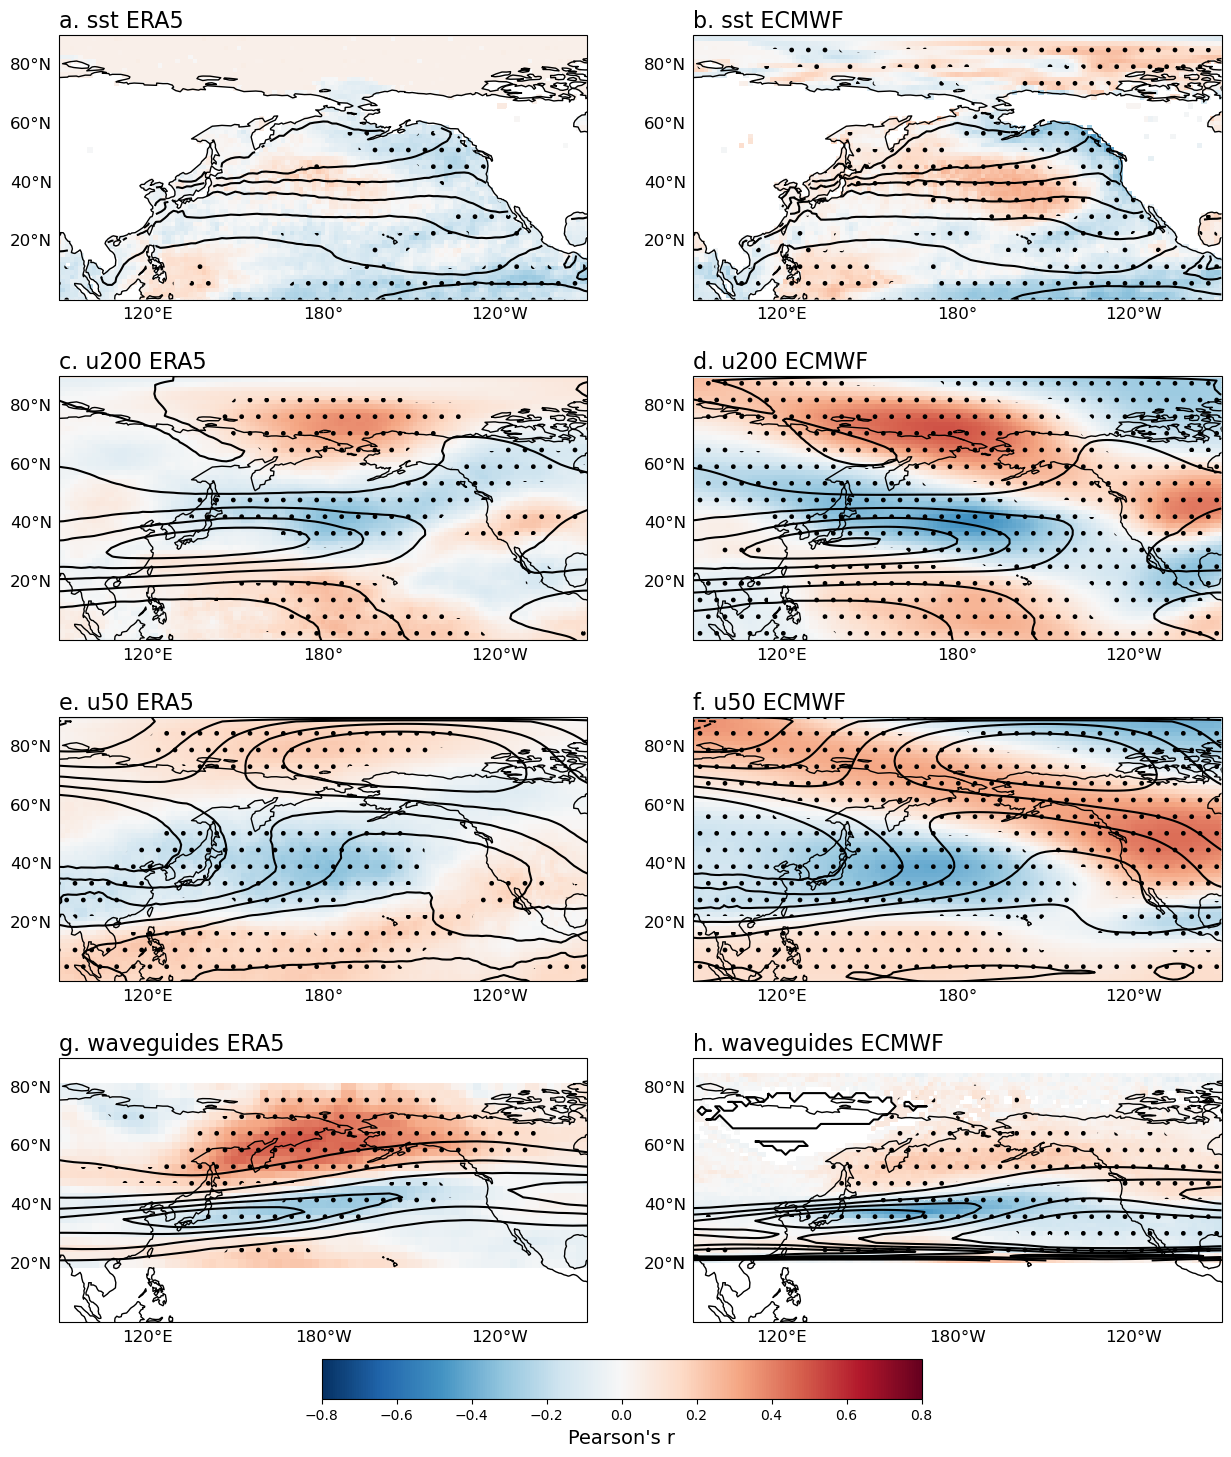

In [38]:
#Plot from files
lets=['a. ','b. ','c. ', 'd. ', 'e. ', 'f. ']
fig=plt.figure(figsize=(15,20))
cm=180
proj = ccrs.PlateCarree(central_longitude=cm)


# cbar_ax = fig.add_axes([0.25, 0.5, 0.5, 0.02])
# fig.colorbar(m, cax=cbar_ax,orientation='horizontal',label="Pearson's r")



ax=fig.add_subplot(421,projection=proj)
cor=rzsstOun.sst#.unstack()
pval = pzsstOun.sst#.unstack()

cor=cor.sel(longitude=slice(90,270))
pval=pval.sel(longitude=slice(90,270))
#Rotate to -180
cor.coords['longitude'] = cor.coords['longitude'] % 360
cor = cor.sortby(cor.longitude)
pval.coords['longitude'] = pval.coords['longitude'] % 360
pval = pval.sortby(pval.longitude)

pval_sig = xr.where(pval<0.05,1,np.nan)

# ax.set_xlim([-30,90])
cor.plot(x='longitude',y='latitude',vmax=0.8,vmin=-0.8, ax=ax, cmap='RdBu_r',transform=ccrs.PlateCarree(),add_colorbar=False)
ax.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())
sst_y1.mean(dim='time').plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(270,310,5), linestyle='--',colors='k')

ax.set_title('')
ax.set_title('a. sst ERA5', fontsize=16, loc='left')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_risst_mt = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.coastlines()
ax.set_xlim([-90,90]) 
ax.set_ylim([0,90]) 

ax=fig.add_subplot(423,projection=proj)
cor=rzuOun.u#.unstack()
pval = pzuOun.u#.unstack()

cor=cor.sel(longitude=slice(90,270))
pval=pval.sel(longitude=slice(90,270))

#Rotate to -180
cor.coords['longitude'] = cor.coords['longitude'] % 360
cor = cor.sortby(cor.longitude)
pval.coords['longitude'] = pval.coords['longitude'] % 360
pval = pval.sortby(pval.longitude)
pval_sig = xr.where(pval<0.05,1,np.nan)


m=cor.plot(x='longitude',y='latitude', ax=ax,vmax=0.8,vmin=-0.8,cmap='RdBu_r', transform=ccrs.PlateCarree(),add_colorbar=False)
ax.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())
u_y1.mean(dim='time').plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(-30,90,15), linestyle='--',colors='k')

ax.set_title('')
ax.set_title('c. u200 ERA5', fontsize=16, loc='left')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_risst_mt = False
gl.ylabels_right = False
#gl.ylabels_left = False
ax.coastlines()
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.set_xlim([-90,90]) 
ax.set_ylim([0,90]) 

ax=fig.add_subplot(425,projection=proj)
cor=rzu50Oun.u#.unstack()
pval = pzu50Oun.u#.unstack()

cor=cor.sel(longitude=slice(90,270))
pval=pval.sel(longitude=slice(90,270))

#Rotate to -180
cor.coords['longitude'] = cor.coords['longitude'] % 360
cor = cor.sortby(cor.longitude)
pval.coords['longitude'] = pval.coords['longitude'] % 360
pval = pval.sortby(pval.longitude)
pval_sig = xr.where(pval<0.05,1,np.nan)


m=cor.plot(x='longitude',y='latitude', ax=ax,vmax=0.8,vmin=-0.8,cmap='RdBu_r', transform=ccrs.PlateCarree(),add_colorbar=False)
ax.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())
(u50_y1.mean(dim='time')).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(-10,25,5), linestyle='--',colors='k')

ax.set_title('')
ax.set_title('e. u50 ERA5', fontsize=16, loc='left')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_risst_mt = False
gl.ylabels_right = False
#gl.ylabels_left = False
ax.coastlines()
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.set_xlim([-90,90]) 
ax.set_ylim([0,90]) 

ax=fig.add_subplot(427,projection=proj)
cor=rzwgOun.ngl_pv_rz#.unstack()
pval = pzwgOun.ngl_pv_rz#.unstack()

cor=cor.sel(longitude=slice(90,270),latitude=slice(80,20))
pval=pval.sel(longitude=slice(90,270),latitude=slice(80,20))
wg_y1=wg_y1.sel(latitude=slice(80,20))
#Rotate to -180
cor.coords['longitude'] = cor.coords['longitude'] % 360
cor = cor.sortby(cor.longitude)
pval.coords['longitude'] = pval.coords['longitude'] % 360
pval = pval.sortby(pval.longitude)
pval_sig = xr.where(pval<0.05,1,np.nan)


m=cor.plot(x='longitude',y='latitude', ax=ax,vmax=0.8,vmin=-0.8,cmap='RdBu_r', transform=ccrs.PlateCarree(),add_colorbar=False)
ax.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())
(wg_y1.mean(dim='time')).plot.contour(ax=ax,transform=ccrs.PlateCarree(), linestyle='--',colors='k')

ax.set_title('')
ax.set_title('g. waveguides ERA5', fontsize=16, loc='left')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_risst_mt = False
gl.ylabels_right = False
#gl.ylabels_left = False
ax.coastlines()
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

gl.ylocator = mticker.FixedLocator([0,20, 40, 60, 80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


ax.set_xlim([-90,90]) 
ax.set_ylim([0,90]) 

ax=fig.add_subplot(422,projection=proj)
cor=rzsstun.sst
pval = pzsstun.sst

#Rotate to -180
cor.coords['longitude'] = cor.coords['longitude'] % 360
cor = cor.sortby(cor.longitude)
pval.coords['longitude'] = pval.coords['longitude'] % 360
pval = pval.sortby(pval.longitude)
pval_sig = xr.where(pval<0.05,1,np.nan)

# ax.set_xlim([-30,90])
cor.plot(x='longitude',y='latitude', ax=ax,vmax=0.8,vmin=-0.8,cmap='RdBu_r', transform=ccrs.PlateCarree(),add_colorbar=False)
ax.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())
yst1.sst.mean(dim=['step','time']).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(270,310,5), linestyle='--',colors='k')

ax.set_title('')
ax.set_title('b. sst ECMWF',fontsize=16, loc='left')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_risst_mt = False
gl.ylabels_right = False
#gl.xlabels_bottom = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.coastlines()

ax.set_xlim([-90,90])
ax.set_ylim([0,90]) 
ax=fig.add_subplot(424,projection=proj)
cor=rzuun.u
pval = pzuun.u

#Rotate to -180
cor.coords['longitude'] = cor.coords['longitude'] % 360
cor = cor.sortby(cor.longitude)
pval.coords['longitude'] = pval.coords['longitude'] % 360
pval = pval.sortby(pval.longitude)

pval_sig = xr.where(pval<0.05,1,np.nan)


# ax.set_xlim([-30,90])
m=cor.plot(x='longitude',y='latitude', ax=ax,vmax=0.8,vmin=-0.8,cmap='RdBu_r',transform=ccrs.PlateCarree(),add_colorbar=False)
ax.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())
yu1.u.mean(dim=['step','time']).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(-30,90,15), linestyle='--',colors='k')

ax.set_title('')
ax.set_title('d. u200 ECMWF',fontsize=16, loc='left')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_risst_mt = False
gl.ylabels_right = False
#gl.xlabels_bottom = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.coastlines()
ax.set_xlim([-90,90]) 
ax.set_ylim([0,90]) 

ax=fig.add_subplot(426,projection=proj)
cor=rzu50un.u
pval = pzu50un.u

#Rotate to -180
cor.coords['longitude'] = cor.coords['longitude'] % 360
cor = cor.sortby(cor.longitude)
pval.coords['longitude'] = pval.coords['longitude'] % 360
pval = pval.sortby(pval.longitude)

pval_sig = xr.where(pval<0.05,1,np.nan)


# ax.set_xlim([-30,90])
m=cor.plot(x='longitude',y='latitude', ax=ax,vmax=0.8,vmin=-0.8,cmap='RdBu_r',transform=ccrs.PlateCarree(),add_colorbar=False)
ax.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())
yu50.u.mean(dim=['step','time']).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(-10,25,5), linestyle='--',colors='k')

ax.set_title('')
ax.set_title('f. u50 ECMWF',fontsize=16, loc='left')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_risst_mt = False
gl.ylabels_right = False
#gl.xlabels_bottom = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.coastlines()
ax.set_xlim([-90,90]) 
ax.set_ylim([0,90]) 

ax=fig.add_subplot(428,projection=proj)
cor=rzwgun.ngl_pv_rz
pval = pzwgun.ngl_pv_rz

#Rotate to -180
cor.coords['longitude'] = cor.coords['longitude'] % 360
cor = cor.sortby(cor.longitude)
pval.coords['longitude'] = pval.coords['longitude'] % 360
pval = pval.sortby(pval.longitude)

pval_sig = xr.where(pval<0.05,1,np.nan)


# ax.set_xlim([-30,90])
m=cor.plot(x='longitude',y='latitude', ax=ax,vmax=0.8,vmin=-0.8,cmap='RdBu_r',transform=ccrs.PlateCarree(),add_colorbar=False)
ax.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())
ywg.ngl_pv_rz.mean(dim=['step','time']).plot.contour(ax=ax,transform=ccrs.PlateCarree(), linestyle='--',colors='k')

ax.set_title('')
ax.set_title('h. waveguides ECMWF',fontsize=16, loc='left')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_risst_mt = False
gl.ylabels_right = False
#gl.xlabels_bottom = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

gl.ylocator = mticker.FixedLocator([0,20, 40, 60, 80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.coastlines()
ax.set_xlim([-90,90]) 
ax.set_ylim([0,90]) 
cbar_ax = fig.add_axes([0.3, 0.18, 0.4, 0.02])
cbl=fig.colorbar(m, cax=cbar_ax,orientation='horizontal')
cbl.set_label(label="Pearson's r",size=14)
#cbl.ax.tick_params(labelsize=16)

plt.subplots_adjust(wspace=0.2,hspace=0.01, bottom=0.2)

#plt.tight_layout()

#plt.show()
plt.savefig('plots/qsw_circulation_ecwmf_era_cor_stackstep_fdr_new.png')
plt.show()

# # Correlate yearly QSW skill with MODEL SSTs, Us, GH data

## calculate metrics across each year and ensemble to look at skill variations

### Use global average skills

In [8]:
#Calculate acc and mss on each year for ensemble mean
accyearly={}
mssyearly={}

for i in range (1):
    fcur1 =forecast_data[models[i]].sel(time=forecast_data[models[i]].time.dt.month.isin([11,12])).mean(dim='number')
    ocur1 = observed_data[models[i]].sel(time=observed_data[models[i]].time.dt.month.isin([11,12]))

    fcur2 =forecast_data[models[i]].sel(time=forecast_data[models[i]].time.dt.month.isin([1,2])).mean(dim='number')
    ocur2 = observed_data[models[i]].sel(time=observed_data[models[i]].time.dt.month.isin([1,2]))

    years = list(set(fcur1.time.dt.year.values))
    years.sort()

    mss_y=xr.zeros_like(fcur1.q.sel(time = fcur1.time.dt.year==years[0]).mean(dim='time'))
    acc_y=xr.zeros_like(fcur1.q.sel(time = fcur1.time.dt.year==years[0]).mean(dim='time'))


    accy = acc_y.expand_dims(years = years).copy()
    mssy = mss_y.expand_dims(years = years).copy()


    for j in range(len(years)):
        #month 12
        fcur11 =fcur1.sel(time = fcur1.time.dt.year==years[j])
        ocur11 = ocur1.sel(time = ocur1.time.dt.year==years[j])
        fcur22 =fcur2.sel(time = fcur2.time.dt.year==years[j]+1)
        ocur22 = ocur2.sel(time = ocur2.time.dt.year==years[j]+1)

        fcur=xr.concat([fcur11,fcur22],dim='time')
        ocur=xr.concat([ocur11,ocur22],dim='time')
        mssur =mss_fun(fcur,ocur)
        #msser=mssur.sel(step=slice(mssur.step[0],mssur.step[16])).mean(dim=['step'])
        accur =acc_fun(fcur,ocur)
        #accer=accur.sel(step=slice(accur.step[0],accur.step[16])).mean(dim=['step'])
        mssy[j,]=mssur.q.values
        accy[j,]=accur.q.values
        
    accyearly[models[i]]=accy
    mssyearly[models[i]]=mssy

### Use pacific average as proxy

In [9]:
#yearly pacific acc (70-50) #MAJOR POINT: Top years should be based on subseasonal skill

accpac_topy={}
accpac_boty={}

topy_pac={}
boty_pac={}

accpacific = {}
for i in range (1):
    accyearly[models[i]].coords['longitude'] = (accyearly[models[i]].coords['longitude'] + 180) % 360 - 180
    accyearly[models[i]] = accyearly[models[i]].sortby(accyearly[models[i]].longitude)
    accy = accyearly[models[i]].copy()
    accy.coords['longitude'] = accy.coords['longitude'] % 360
    accy = accy.sortby(accy.longitude)
    accy_pacific=accy.sel(longitude=slice(150,270),latitude=slice(70,50))
    accspy_pac = accy_pacific.mean(dim=['latitude', 'longitude'])
    
    #MAJOR POINT: Top years should be based on subseasonal skill
    accspy_st_pac=accspy_pac.isel(step=slice(14,28)).mean(dim='step')
    accspy_st_pacav=accspy_st_pac.mean(dim='years')
    accspy_st_pacsd=accspy_st_pac.std(dim='years')
    
    accspsty_topn=accspy_st_pac.where(accspy_st_pac>accspy_st_pacav+accspy_st_pacsd).dropna(dim='years')
    accpac_topy[models[i]]=accyearly[models[i]].sel(years=accspsty_topn.years).mean(dim='years')
    
    accspsty_botn=accspy_st_pac.where(accspy_st_pac<accspy_st_pacav-accspy_st_pacsd).dropna(dim='years')
    accpac_boty[models[i]]=accyearly[models[i]].sel(years=accspsty_botn.years).mean(dim='years')
    
    boty_pac[models[i]]=accspsty_botn.years
    topy_pac[models[i]]=accspsty_topn.years
    
    accpacific[models[i]] = accy_pacific

In [10]:
#Prepare QSW skill values as x for correlation (90-270)

xs = []
for i in range (1):
    accyearly[models[i]].coords['longitude'] = (accyearly[models[i]].coords['longitude'] + 180) % 360 - 180
    accyearly[models[i]] = accyearly[models[i]].sortby(accyearly[models[i]].longitude)
    accy = accyearly[models[i]].copy()
    accy.coords['longitude'] = accy.coords['longitude'] % 360
    accy = accy.sortby(accy.longitude)
    accy_pacific=accy.sel(longitude=slice(90,270),latitude=slice(70,50))

    x= accy_pacific.isel(step=slice(6,21)).mean(dim=['step','latitude','longitude'])
    xs.append(x)
x1 = xs[0]
# x2=xs[1]
# x3=xs[2]
# x4=xs[3]

In [11]:
#Get model sst
modely_sst={}
for i in range(1):
    model_sst_pac= xr.open_dataset('v300/sst/'+models[i]+'/output/sst_pacific2_'+models[i]+'_fullfield_eq_forecasted.nc')
    model_sst_pac=model_sst_pac.sel(time = model_sst_pac.time.dt.month.isin([12,1,2]))
    model_sst_pac = model_sst_pac.sel(time=model_sst_pac.time.dt.year.isin(x1.years))
    
    fir =model_sst_pac.sel(time=model_sst_pac.time.dt.month.isin([12]))
    sec = model_sst_pac.sel(time=model_sst_pac.time.dt.month.isin([1,2]))

    years = list(set(fir.time.dt.year.values))
    years.sort()

    model_yy=xr.zeros_like(fir.sel(time = fir.time.dt.year==years[0]).mean(dim='time'))

    model_yst = model_yy.sst.expand_dims(years = years).copy()

    for j in range(len(years)-1):
    #month 12
        modelfir = model_sst_pac.sel(time = model_sst_pac.time.dt.year==years[j])
        modelsec = model_sst_pac.sel(time = model_sst_pac.time.dt.year==years[j]+1)


        model_now=xr.concat([modelfir,modelsec],dim='time')
        model_mn = model_now.mean(dim = 'time')

        model_yst[j,]=model_mn.sst.values
    modely_sst[models[i]]=model_yst

In [12]:
#Get model u at 200 
model_u_pac= xr.open_dataset('u/ecmwf/output/ufull_pacific2_'+models[0]+'_eq_forecasted.nc')
model_u_pac=model_u_pac.sel(time = model_u_pac.time.dt.month.isin([12,1,2]))
model_u_pac = model_u_pac.sel(time=model_u_pac.time.dt.year.isin(x1.years))

fir =model_u_pac.sel(time=model_u_pac.time.dt.month.isin([12]))
sec = model_u_pac.sel(time=model_u_pac.time.dt.month.isin([1,2]))

years = list(set(fir.time.dt.year.values))
years.sort()

model_yy=xr.zeros_like(fir.sel(time = fir.time.dt.year==years[0]).mean(dim='time'))

model_yu = model_yy.u.expand_dims(years = years).copy()

for j in range(len(years)-1):
#month 12
    modelfir = model_u_pac.sel(time = model_u_pac.time.dt.year==years[j])
    modelsec = model_u_pac.sel(time = model_u_pac.time.dt.year==years[j]+1)


    model_now=xr.concat([modelfir,modelsec],dim='time')
    model_mn = model_now.mean(dim = 'time')

    model_yu[j,]=model_mn.u.values

In [13]:
# Get model waveguides

model_wg_pac=xr.open_dataset('pv/models_utv/'+models[i]+'/output/waveguide_forecast_320_threshold.nc')
model_wg_pac=model_wg_pac.sel(time = model_wg_pac.time.dt.month.isin([12,1,2]))
model_wg_pac = model_wg_pac.sel(time=model_wg_pac.time.dt.year.isin(x1.years))

fir =model_wg_pac.sel(time=model_wg_pac.time.dt.month.isin([12]))
sec = model_wg_pac.sel(time=model_wg_pac.time.dt.month.isin([1,2]))

years = list(set(fir.time.dt.year.values))
years.sort()

model_yy=xr.zeros_like(fir.sel(time = fir.time.dt.year==years[0]).mean(dim='time'))

model_ywg = model_yy.ngl_pv_rz.expand_dims(years = years).copy()

for j in range(len(years)-1):
#month 12
    modelfir = model_wg_pac.sel(time = model_wg_pac.time.dt.year==years[j])
    modelsec = model_wg_pac.sel(time = model_wg_pac.time.dt.year==years[j]+1)


    model_now=xr.concat([modelfir,modelsec],dim='time')
    model_mn = model_now.mean(dim = 'time')

    model_ywg[j,]=model_mn.ngl_pv_rz.values


In [14]:
#Get model u at 50
model_u50_pac= xr.open_dataset('u50/ecmwf/output/u50_pacific2_'+models[0]+'_eq_forecasted.nc')
model_u50_pac=model_u50_pac.sel(time = model_u50_pac.time.dt.month.isin([12,1,2]))
model_u50_pac = model_u50_pac.sel(time=model_u50_pac.time.dt.year.isin(x1.years))

fir =model_u50_pac.sel(time=model_u50_pac.time.dt.month.isin([12]))
sec = model_u50_pac.sel(time=model_u50_pac.time.dt.month.isin([1,2]))

years = list(set(fir.time.dt.year.values))
years.sort()

model_yy=xr.zeros_like(fir.sel(time = fir.time.dt.year==years[0]).mean(dim='time'))

model_yu50 = model_yy.u.expand_dims(years = years).copy()

for j in range(len(years)-1):
#month 12
    modelfir = model_u50_pac.sel(time = model_u50_pac.time.dt.year==years[j])
    modelsec = model_u50_pac.sel(time = model_u50_pac.time.dt.year==years[j]+1)


    model_now=xr.concat([modelfir,modelsec],dim='time')
    model_mn = model_now.mean(dim = 'time')

    model_yu50[j,]=model_mn.u.values

In [15]:
#prepare y values from model vars
y_sst =modely_sst[models[0]].isel(step=slice(14,29)).mean(dim = ['step','number'])
y_u =model_yu.isel(step=slice(14,29)).mean(dim = ['step','number'])
y_wg =model_ywg.isel(step=slice(14,29)).mean(dim = ['step','number'])
y_u50 =model_yu50.isel(step=slice(14,29)).mean(dim = ['step','number'])

yu1 = y_u.isel(years=slice(0,-1))
yst1 = y_sst.isel(years=slice(0,-1))
ywg1 = y_wg.isel(years=slice(0,-1))
yu50 = y_u50.isel(years=slice(0,-1))

In [16]:
#correlate values
#.stack(z={'latitude','longitude'})

#y1 = y1.isel(years=slice(0,-1))
#y2 = y2.isel(years=slice(0,-1))


xx=x1.isel(years=slice(0,-1))


ysst_cut= yst1.stack(z={'latitude','longitude'})
yu_cut= yu1.stack(z={'latitude','longitude'})
yu50_cut= yu50.stack(z={'latitude','longitude'})
ywg_cut= ywg1.stack(z={'latitude','longitude'})

rzu=yu_cut.copy(deep=True).isel(years=0)
pzu=yu_cut.copy(deep=True).isel(years=0)

rzu50=yu50_cut.copy(deep=True).isel(years=0)
pzu50=yu50_cut.copy(deep=True).isel(years=0)


rzsst=ysst_cut.copy(deep=True).isel(years=0)
pzsst=ysst_cut.copy(deep=True).isel(years=0)

for i in range(len(ysst_cut.z)):
    try:
        cor1,corp1 = pcor(xx[:].values,ysst_cut[:,i].values)

        rzsst[i] = cor1
        pzsst[i] = corp1
    
    except:
        rzsst[i] = np.nan
        pzsst[i] = np.nan

    
for i in range(len(yu_cut.z)):    
    cor2,corp2 = pcor(xx[:].values,yu_cut[:,i].values)
    rzu[i] = cor2
    pzu[i] = corp2
    
for i in range(len(yu50_cut.z)):    
    cor2,corp2 = pcor(xx[:].values,yu50_cut[:,i].values)
    rzu50[i] = cor2
    pzu50[i] = corp2
    

ywg1.coords['longitude'] = ywg1.coords['longitude'] % 360
ywg1 = ywg1.sortby(ywg1.longitude)
ywg1=ywg1.sel(longitude=slice(90,270))

    
rzwg=ywg_cut.copy(deep=True).isel(years=0)
pzwg=ywg_cut.copy(deep=True).isel(years=0)

for i in range(len(ywg_cut.z)):    
    cor3,corp3 = pcor(xx[:].values,ywg_cut[:,i].values)
    rzwg[i] = cor3
    pzwg[i] = corp3

In [19]:
#save pvalues
pzu.unstack().to_netcdf('u_pvals_skills.nc')
pzsst.unstack().to_netcdf('sst_pvals_skills.nc')
pzu50.unstack().to_netcdf('u50_pvals_skills.nc')
pzwg.unstack().to_netcdf('wg_pvals_skills.nc')


In [20]:
#save correlations
rzu.unstack().to_netcdf('u_skills_rz.nc')
rzsst.unstack().to_netcdf('sst_skills_rz.nc')
rzu50.unstack().to_netcdf('u50_skills_rz.nc')
rzwg.unstack().to_netcdf('wg_skills_rz.nc')

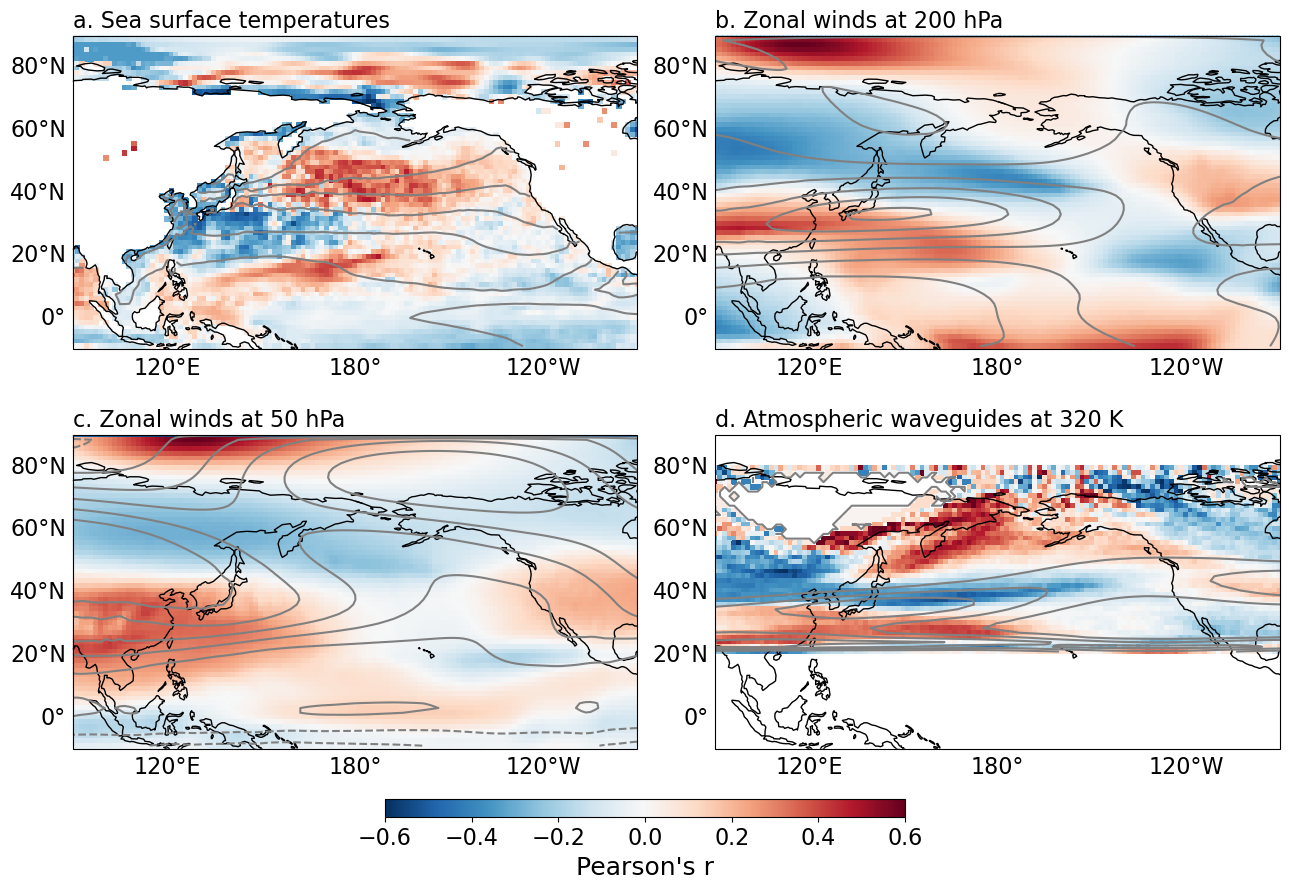

In [19]:
#Plot correlation (ECMWF) between QSW skill and SST, U200 and GH (70-50)
fig=plt.figure(figsize=(13,9))
cm=180
proj = ccrs.PlateCarree(central_longitude=cm)

lets=['a. ','b. ','c. ', 'd. ']
ax1=fig.add_subplot(221,projection=proj)
corr=rzsst.unstack()
pval = pzsst.unstack()
pval_sig = xr.where(pval<0.05,1,np.nan)


ax1.set_xlim([-90,90])
ax1.set_ylim([-10,90])
corr.plot(x='longitude',y='latitude', ax=ax1, transform=ccrs.PlateCarree(), add_colorbar= False)#,cbar_kwargs={'label': "Pearson's r",'pad':0.05,"orientation":"horizontal"})
#ax1.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())
yst1.mean(dim='years').plot.contour(ax=ax1,transform=ccrs.PlateCarree(),levels=np.arange(270,310,5), linestyle='--',colors='0.5')

# ax1.add_patch(mpatches.Rectangle(xy=[150, 35], width=70, height=20,
#                                 facecolor='none', edgecolor='k',lw=2,
#                                 transform=ccrs.PlateCarree()))

# ax1.add_patch(mpatches.Rectangle(xy=[120, 20], width=60, height=15,
#                                 facecolor='none', edgecolor='k',lw=2,
#                                 transform=ccrs.PlateCarree()))


ax1.set_title('')
ax1.set_title('a. Sea surface temperatures', fontsize=16,  loc='left')
gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_rit2mt = False


gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}
ax1.coastlines()

ax1=fig.add_subplot(222,projection=proj)
corr=rzu.unstack()
pval = pzu.unstack()
pval_sig = xr.where(pval<0.05,1,np.nan)


ax1.set_xlim([-90,90])
ax1.set_ylim([-10,90])
corr.plot(x='longitude',y='latitude', ax=ax1, transform=ccrs.PlateCarree(), add_colorbar= False)#,cbar_kwargs={'label': "Pearson's r",'pad':0.05,"orientation":"horizontal"})
#ax1.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())
yu1.mean(dim='years').plot.contour(ax=ax1,transform=ccrs.PlateCarree(),levels=np.arange(-15,90,15), linestyle='--',colors='0.5')


# ax1.add_patch(mpatches.Rectangle(xy=[90.5, 35], width=120, height=30,
#                                 facecolor='none', edgecolor='k',lw=2,
#                                 transform=ccrs.PlateCarree()))

# ax1.add_patch(mpatches.Rectangle(xy=[90.5, 15], width=100, height=20,
#                                 facecolor='none', edgecolor='k',lw=2,
#                                 transform=ccrs.PlateCarree()))


ax1.set_title('')
ax1.set_title('b. Zonal winds at 200 hPa', fontsize=16,  loc='left')
gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_rit2mt = False

gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}
ax1.coastlines()

ax1=fig.add_subplot(223,projection=proj)
corr=rzu50.unstack()
pval = pzu50.unstack()
pval_sig = xr.where(pval<0.05,1,np.nan)


ax1.set_xlim([-90,90])
ax1.set_ylim([-10,90])
corr.plot(x='longitude',y='latitude', ax=ax1, transform=ccrs.PlateCarree(), add_colorbar= False)#,cbar_kwargs={'label': "Pearson's r",'pad':0.05,"orientation":"horizontal"})
#ax1.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())
yu50.mean(dim='years').plot.contour(ax=ax1,transform=ccrs.PlateCarree(),levels=np.arange(-10,25,5), linestyle='--',colors='0.5')


# ax1.add_patch(mpatches.Rectangle(xy=[90.5, 40], width=120, height=30,
#                                 facecolor='none', edgecolor='k',lw=2,
#                                 transform=ccrs.PlateCarree()))

# ax1.add_patch(mpatches.Rectangle(xy=[90.5, 15], width=90, height=25,
#                                 facecolor='none', edgecolor='k',lw=2,
#                                 transform=ccrs.PlateCarree()))


ax1.set_title('')
ax1.set_title('c. Zonal winds at 50 hPa', fontsize=16,  loc='left')
gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_rit2mt = False

gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}
ax1.coastlines()


ax1=ax1=fig.add_subplot(224,projection=proj)
cor=rzwg.unstack()
pval = pzwg.unstack()
pval_sig = xr.where(pval<0.05,1,np.nan)

cor=cor.sel(latitude=slice(80,20))
pval_sig=pval_sig.sel(latitude=slice(90,20))
ywg1=ywg1.sel(latitude=slice(80,20))

m=cor.plot(x='longitude',y='latitude', ax=ax1,vmax=0.6,vmin=-0.6, cmap='RdBu_r', transform=ccrs.PlateCarree(), add_colorbar= False)#cbar_kwargs={'label': "Pearson's r",'pad':0.05,"orientation":"horizontal"})
#ax1.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())
ywg1.mean(dim='years').plot.contour(ax=ax1,transform=ccrs.PlateCarree(),levels=np.arange(0,1,0.2), linestyle='--',colors='0.5')

# ax1.add_patch(mpatches.Rectangle(xy=[130, 50], width=90, height=15,
#                                 facecolor='none', edgecolor='k',lw=2,
#                                 transform=ccrs.PlateCarree()))
# ax1.add_patch(mpatches.Rectangle(xy=[90.5, 35], width=110, height=10,
#                                 facecolor='none', edgecolor='k',lw=2,
#                                 transform=ccrs.PlateCarree()))


ax1.set_title('')
ax1.set_title('d. Atmospheric waveguides at 320 K', fontsize=16,  loc='left')
ax1.set_ylim([-10,90])
ax1.set_xlim([-90,90])

gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
#gl.ylabels_left = False
gl.ylabels_rit2mt = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}
ax1.coastlines()

cbar_ax = fig.add_axes([0.3, 0.07, 0.4, 0.02])
cbl=fig.colorbar(m, cax=cbar_ax,orientation='horizontal')
cbl.set_label(label="Pearson's r",size=18)
cbl.ax.tick_params(labelsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.01, bottom=0.1)

#plt.tight_layout()

#ax.coastlines()
plt.savefig('plots/skill_vs_circulation_cor_fdr.png')
plt.show()

# # Correlate QSW and blocking/t2m

### Yearly

In [ ]:
#QSWs in the pacific (70-50)
qsw_yearly={}

for i in range (1):
    
    fcur1 =forecast_data[models[i]].sel(time=forecast_data[models[i]].time.dt.month.isin([11,12])).mean(dim='number')
    #ocur1 = observed_data[models[i]].sel(time=observed_data[models[i]].time.dt.month.isin([11,12]))

    fcur2 =forecast_data[models[i]].sel(time=forecast_data[models[i]].time.dt.month.isin([1,2])).mean(dim='number')
    #ocur2 = observed_data[models[i]].sel(time=observed_data[models[i]].time.dt.month.isin([1,2]))

    years = list(set(fcur1.time.dt.year.values))
    years.sort()

    qsw_y=xr.zeros_like(fcur1.q.sel(time = fcur1.time.dt.year==years[0])).mean(dim='time')


    qsw_y = acc_y.expand_dims(years = years).copy()
    qsw_sd = acc_y.expand_dims(years = years).copy()


    for j in range(len(years)):
        #month 12
        fcur11 =fcur1.sel(time = fcur1.time.dt.year==years[j])
        #ocur11 = ocur1.sel(time = ocur1.time.dt.year==years[j])
        fcur22 =fcur2.sel(time = fcur2.time.dt.year==years[j]+1)
        #ocur22 = ocur2.sel(time = ocur2.time.dt.year==years[j]+1)

        fcur=xr.concat([fcur11,fcur22],dim='time')
        #ocur=xr.concat([ocur11,ocur22],dim='time')

        qsw_cur = fcur.mean(dim='time')
        qsw_ysd = fcur.rolling(time=6, center=True).std()
        qsw_y[j,]=qsw_cur.q.values
        qsw_sd[j,]=qsw_ysd.q.mean(dim='time').values
        
        
    qsw_yearly[models[i]]=qsw_y


    qsw_yearly[models[i]].coords['longitude'] = qsw_yearly[models[i]].coords['longitude'] % 360
    qsw_yearly[models[i]] = qsw_yearly[models[i]].sortby(qsw_yearly[models[i]].longitude)
    
    qsw_yearly[models[i]]=qsw_yearly[models[i]].sel(latitude=slice(70,50))
    
    qsw_yearly[models[i]].coords['longitude'] = (qsw_yearly[models[i]].coords['longitude'] + 180) % 360 - 180
    qsw_yearly[models[i]] = qsw_yearly[models[i]].sortby(qsw_yearly[models[i]].longitude)
    
    qsw_sd.coords['longitude'] = qsw_sd.coords['longitude'] % 360
    qsw_sd = qsw_sd.sortby(qsw_sd.longitude)
    
    qsw_sd=qsw_sd.sel(latitude=slice(70,50))
    
    qsw_sd.coords['longitude'] = (qsw_sd.coords['longitude'] + 180) % 360 - 180
    qsw_sd = qsw_sd.sortby(qsw_sd.longitude)

In [9]:
#Get model t2m
modely_t2m={}
for i in range(1):
    model_t2m_pac= xr.open_dataset('t2m/'+models[i]+'/output/t2m_'+models[i]+'_forecasted.nc')
    model_t2m_pac=model_t2m_pac.sel(time = model_t2m_pac.time.dt.month.isin([12,1,2]))
    model_t2m_pac=model_t2m_pac.sel(time=model_t2m_pac.time.dt.year.isin(x1.years))
    fir =model_t2m_pac.sel(time=model_t2m_pac.time.dt.month.isin([12]))
    sec = model_t2m_pac.sel(time=model_t2m_pac.time.dt.month.isin([1,2]))

    years = list(set(fir.time.dt.year.values))
    years.sort()

    model_yy=xr.zeros_like(fir.sel(time = fir.time.dt.year==years[0]).mean(dim='time'))

    model_yst = model_yy.t2m.expand_dims(years = years).copy()

    for j in range(len(years)-1):
    #month 12
        modelfir = model_t2m_pac.sel(time = model_t2m_pac.time.dt.year==years[j])
        modelsec = model_t2m_pac.sel(time = model_t2m_pac.time.dt.year==years[j]+1)


        model_now=xr.concat([modelfir,modelsec],dim='time')
        model_mn = model_now.mean(dim = 'time')

        model_yst[j,]=model_mn.t2m.values
    modely_t2m[models[i]]=model_yst

KeyboardInterrupt: 

In [52]:
#Get model blocking
modely_block={}
for i in range(1):
    model_block_pac= xr.open_dataset('new_gph/Blocking_forecasted_ecmwf.nc')
    model_block_pac=model_block_pac.sel(time = model_block_pac.time.dt.month.isin([12,1,2]))
    model_block_pac=model_block_pac.sel(time=model_block_pac.time.dt.year.isin(x1.years))
    
    fir =model_block_pac.sel(time=model_block_pac.time.dt.month.isin([12]))
    sec = model_block_pac.sel(time=model_block_pac.time.dt.month.isin([1,2]))

    years = list(set(fir.time.dt.year.values))
    years.sort()

    model_yy=xr.zeros_like(fir.sel(time = fir.time.dt.year==years[0]).mean(dim='time'))

    model_yst = model_yy.block.expand_dims(years = years).copy()

    for j in range(len(years)-1):
    #month 12
        modelfir = model_block_pac.sel(time = model_block_pac.time.dt.year==years[j])
        modelsec = model_block_pac.sel(time = model_block_pac.time.dt.year==years[j]+1)


        model_now=xr.concat([modelfir,modelsec],dim='time')
        model_mn = model_now.mean(dim = 'time')

        model_yst[j,]=model_mn.block.values
    modely_block[models[i]]=model_yst

In [159]:
#Prepare QSW  values as x for correlation

xs = []
for i in range (1):
    qsw_yearly[models[i]].coords['longitude'] = (qsw_yearly[models[i]].coords['longitude'] + 180) % 360 - 180
    qsw_yearly[models[i]] = qsw_yearly[models[i]].sortby(qsw_yearly[models[i]].longitude)

    qsw_am=qsw_yearly[models[i]].sel(latitude=slice(80,20))#,longitude=slice(-180,-20))

    x= qsw_am.isel(step=slice(8,22)).mean(dim=['step'])
    xlat = x.rolling(latitude=5,center=True).mean()
    xlon=xlat.rolling(longitude=5,center=True).mean()
    xcut=xlon.isel(latitude=slice(2,-2),longitude=slice(2,-2))
    xstack=xcut.stack(z={'latitude','longitude'})
    
    #xs.append(xstack)
    xs.append(xstack)
x1 = xs[0]


NameError: name 'qsw_yearly' is not defined

In [54]:
#prep and cut up data
model_t2m_pac= xr.open_dataset('t2m/'+models[0]+'/output/t2m_'+models[0]+'_forecasted.nc')
model_t2m_pac.coords['longitude']=(model_t2m_pac.coords['longitude'] + 180) % 360 - 180
model_t2m_pac = model_t2m_pac.sortby(model_t2m_pac.longitude)
model_t2m_pac=model_t2m_pac.sel(time=model_t2m_pac.time.dt.year.isin(x1.years))

t2m_mod =model_t2m_pac.sel(latitude=slice(80,20))#,longitude=slice(-180,-20))
t2m_modabs=abs(t2m_mod.groupby('time.dayofyear') - t2m_mod.groupby('time.dayofyear').mean(dim='time'))

t2m_modyr = yearly_winters(t2m_modabs)
block_mod = modely_block[models[0]].sel(latitude=slice(80,20))#,longitude=slice(-180,-20))

ycutT2=t2m_modyr.isel(latitude=slice(2,-2),longitude=slice(2,-2))
y1=ycutT2.stack(z={'latitude','longitude'}).isel(years=slice(0,-1))
ycutBL=block_mod.isel(latitude=slice(2,-2),longitude=slice(2,-2))
y2=ycutBL.stack(z={'latitude','longitude'}).isel(years=slice(0,-1))

In [56]:
#Correlate each var with qsw
xx1=x1.isel(years=slice(0,-1))
yy1=y1.isel(step=slice(8,22)).mean(dim=['step','number'])
yy2=y2.isel(step=slice(8,22)).mean(dim=['step','number'])

rzt2m=yy1.copy(deep=True).isel(years=0)
pzt2m=yy1.copy(deep=True).isel(years=0)


rzblock=yy2.copy(deep=True).isel(years=0)
pzblock=yy2.copy(deep=True).isel(years=0)

for i in range(len(y1.z)):
    try:
        cor1,corp1 = pcor(xx1[:,i].values,yy1[:,i].values)

        rzt2m[i] = cor1
        pzt2m[i] = corp1
    
    except:
        rzt2m[i] = np.nan
        pzt2m[i] = np.nan

    
for i in range(len(y2.z)):
    try:
        cor4,corp4 = pcor(xx1[:,i].values,yy2[:,i].values)
        rzblock[i] = cor4
        pzblock[i] = corp4
    except:
        rzblock[i] = np.nan
        pzblock[i] = np.nan

In [60]:
#read era5 u50 and NOAA MJO indices
t2m_era = xr.open_dataset('t2m/era5/era5_daily_t2m_1990-2022.nc')
blockera = xr.open_dataset('new_gph/Blocking_observed_final_era5.nc')
qswera = xr.open_dataset('predict/ERA5_Q_1.5_Winter.nc')

t2mera_abs=abs(t2m_era.groupby('time.dayofyear') - t2m_era.groupby('time.dayofyear').mean(dim='time'))

In [61]:
#yearly winters
t2m_sel=select_yrmo(t2mera_abs)
block_sel=select_yrmo(blockera)
qsw_sel=select_yrmo(qswera)

t2m_yr = yearly_winters(t2m_sel)
block_yr = yearly_winters(block_sel)
qsw_yr = yearly_winters(qsw_sel)

In [62]:
#prep and cut up data
qsw_cut = qsw_yr.sel(latitude=slice(80,20))#,longitude=slice(-180,-20))
t2m_cut = t2m_yr.sel(latitude=slice(80,20))#,longitude=slice(-180,-20))
block_cut = block_yr.sel(latitude=slice(80,20))#,longitude=slice(-180,-20))

t2msliced=t2m_cut.isel(latitude=slice(2,-2),longitude=slice(2,-2))
y1o=t2msliced.stack(z={'latitude','longitude'}).isel(years=slice(0,-1))
blocksliced=block_cut.isel(latitude=slice(2,-2),longitude=slice(2,-2))
y2o=blocksliced.stack(z={'latitude','longitude'}).isel(years=slice(0,-1))

In [64]:
#Correlate each var with qsw
#Cut all dat to 25 years because last year often faulty

#Correlate each var with qsw


xx1=x1_o.isel(years=slice(0,-1))
xx2=x2_o.isel(years=slice(0,-1))

rzt2mo=y1o.copy(deep=True).isel(years=0)
pzt2mo=y1o.copy(deep=True).isel(years=0)


rzblocko=y2o.copy(deep=True).isel(years=0)
pzblocko=y2o.copy(deep=True).isel(years=0)

for i in range(len(y1o.z)):
    try:
        cor1,corp1 = pcor(xx2[:,i].values,y1o[:,i].values)

        rzt2mo[i] = cor1
        pzt2mo[i] = corp1
    
    except:
        rzt2mo[i] = np.nan
        pzt2mo[i] = np.nan

    
for i in range(len(y2o.z)):
    try:
        cor4,corp4 = pcor(xx1[:,i].values,y2o[:,i].values)
        rzblocko[i] = cor4
        pzblocko[i] = corp4
    except:
        rzblocko[i] = np.nan
        pzblocko[i] = np.nan

In [39]:
#save files for FDR
pzt2mo.unstack().to_netcdf('t2m_pvals_Oampl.nc')
pzblocko.unstack().to_netcdf('block_pvals_Oampl.nc')


In [ ]:
#Plot correlation (ECMWF) between QSW skill and SST, U200 and GH

lets=['a. ','b. ','c. ', 'd. ']
fig=plt.figure(figsize=(19,6))
cm=180
proj = ccrs.PlateCarree(central_longitude=cm)



# cbar_ax = fig.add_axes([0.25, 0.5, 0.5, 0.02])
# fig.colorbar(m, cax=cbar_ax,orientation='horizontal',label="Pearson's r")

ax=fig.add_subplot(221,projection=proj)
cor=rzt2mo.unstack()
pval = pzt2mo.unstack()

#Rotate to -180
cor.coords['longitude'] = cor.coords['longitude'] % 360
cor = cor.sortby(cor.longitude)
pval.coords['longitude'] = pval.coords['longitude'] % 360
pval = pval.sortby(pval.longitude)

pval_sig = xr.where(pval<0.05,1,np.nan)

# ax.set_xlim([-30,90])
cor.plot(x='longitude',y='latitude',vmax=0.8,vmin=-0.8, ax=ax, cmap='RdBu_r',transform=ccrs.PlateCarree(),add_colorbar=False)
ax.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values.T,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())

ax.set_title('')
ax.set_title(lets[0]+'T2m ERA5', fontsize=16, loc = 'left')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_rit2mt = False
gl.ylabels_right = False
gl.xlabels_bottom = False

gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.coastlines()

ax=fig.add_subplot(222,projection=proj)
cor=rzblocko.unstack()
pval = pzblocko.unstack()

#Rotate to -180
cor.coords['longitude'] = cor.coords['longitude'] % 360
cor = cor.sortby(cor.longitude)
pval.coords['longitude'] = pval.coords['longitude'] % 360
pval = pval.sortby(pval.longitude)
pval_sig = xr.where(pval<0.05,1,np.nan)

# ax.set_xlim([-30,90])
m=cor.plot(x='longitude',y='latitude', ax=ax,vmax=0.8,vmin=-0.8,cmap='RdBu_r', transform=ccrs.PlateCarree(),add_colorbar=False)
ax.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values.T,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())

ax.set_title('')
ax.set_title(lets[1]+'Blocking ERA5', fontsize=16, loc = 'left')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_rit2mt = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlabels_bottom = False 

ax.coastlines()
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

ax=fig.add_subplot(223,projection=proj)
cor=rzt2m.unstack()
pval = pzt2m.unstack()

#Rotate to -180
cor.coords['longitude'] = cor.coords['longitude'] % 360
cor = cor.sortby(cor.longitude)
pval.coords['longitude'] = pval.coords['longitude'] % 360
pval = pval.sortby(pval.longitude)
pval_sig = xr.where(pval<0.05,1,np.nan)

# ax.set_xlim([-30,90])
cor.plot(x='longitude',y='latitude', ax=ax,vmax=0.8,vmin=-0.8,cmap='RdBu_r', transform=ccrs.PlateCarree(),add_colorbar=False)
ax.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values.T,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())

ax.set_title('')
ax.set_title(lets[2]+'T2m ECMWF',fontsize=16, loc = 'left')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_rit2mt = False
gl.ylabels_right = False

gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.coastlines()


ax=fig.add_subplot(224,projection=proj)
cor=rzblock.unstack()
pval = pzblock.unstack()
#Rotate to -180
cor.coords['longitude'] = cor.coords['longitude'] % 360
cor = cor.sortby(cor.longitude)
pval.coords['longitude'] = pval.coords['longitude'] % 360
pval = pval.sortby(pval.longitude)

pval_sig = xr.where(pval<0.05,1,np.nan)


# ax.set_xlim([-30,90])
m=cor.plot(x='longitude',y='latitude', ax=ax,vmax=0.8,vmin=-0.8,cmap='RdBu_r',transform=ccrs.PlateCarree(),add_colorbar=False)
ax.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values.T,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())

ax.set_title('')
ax.set_title(lets[3]+'Blocking ECMWF',fontsize=16, loc = 'left')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False

gl.ylabels_rit2mt = False
gl.ylabels_left = False
gl.ylabels_right = False

gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.coastlines()

cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.02])
cbl=fig.colorbar(m, cax=cbar_ax,orientation='horizontal')
cbl.set_label(label="Pearson's r",size=16)
cbl.ax.tick_params(labelsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.001, bottom=0.2)

# plt.tight_layout()
plt.savefig('plots/QSW_vs_extremes_ecmef_era_cor_05.png')
plt.show()